In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import warnings
import math
from math import sqrt
import time
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


## 1. Energy demand - Load consumption data


|Data                |Granularity |Year range|
|--------------------|------------|----------|
|Load consumption    |hourly      |2006-2025 |

In [2]:
# Load the dataset to explore trends and patterns
data_path = 'loadConsumption/data_2006_2025.csv'
data = pd.read_csv(data_path)

# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173107 entries, 0 to 173106
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   loadConsumption  173107 non-null  float64
 1   date             173107 non-null  object 
 2   datetime         173107 non-null  object 
 3   Hour             173107 non-null  int64  
 4   Year             173107 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 6.6+ MB


In [ ]:
data.describe()

In [13]:
# Convert 'datetime' to pandas datetime for time-series operations
data['datetime'] = pd.to_datetime(data['datetime'])
data['date'] = pd.to_datetime(data['date'])

### Visualisation of energy load time series

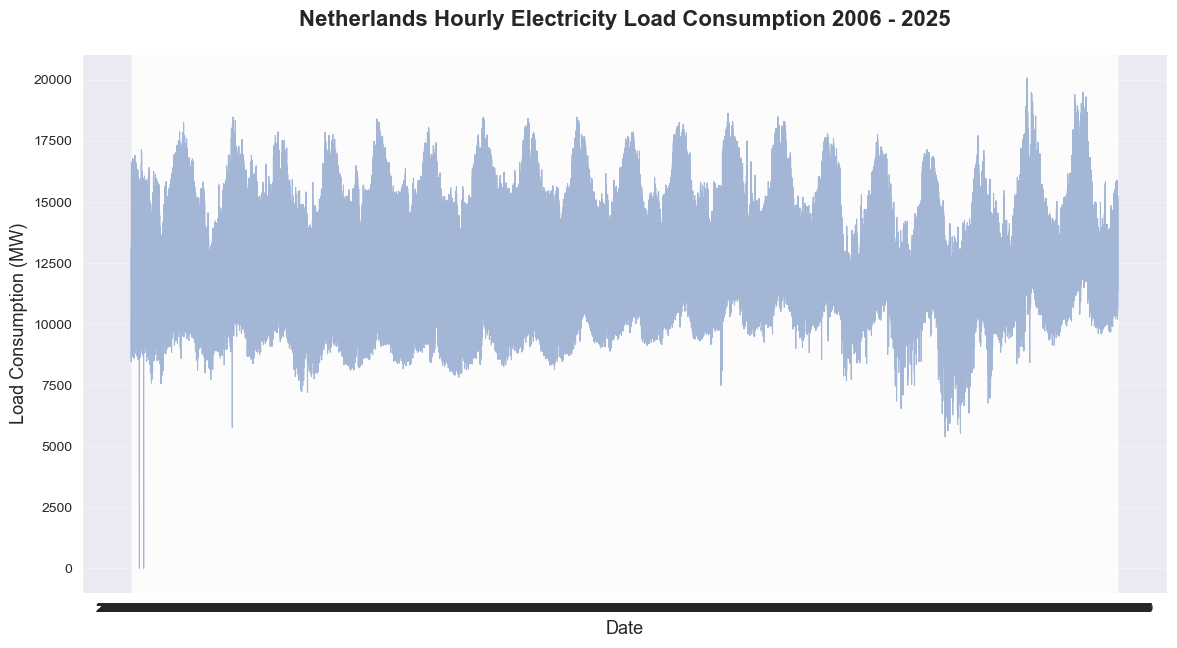

In [ ]:
# Set seaborn style
sns.set_style("darkgrid")
sns.set_palette('deep')

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['loadConsumption'], label='Hourly Load Consumption', alpha=0.5, linewidth=0.8)

# Add title and labels
plt.title('Netherlands Hourly Electricity Load Consumption 2006 - 2025', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Load Consumption (MW)', fontsize=13)


plt.savefig("plots/load_consumption_timeseries.png", dpi=300, bbox_inches='tight')

plt.show()

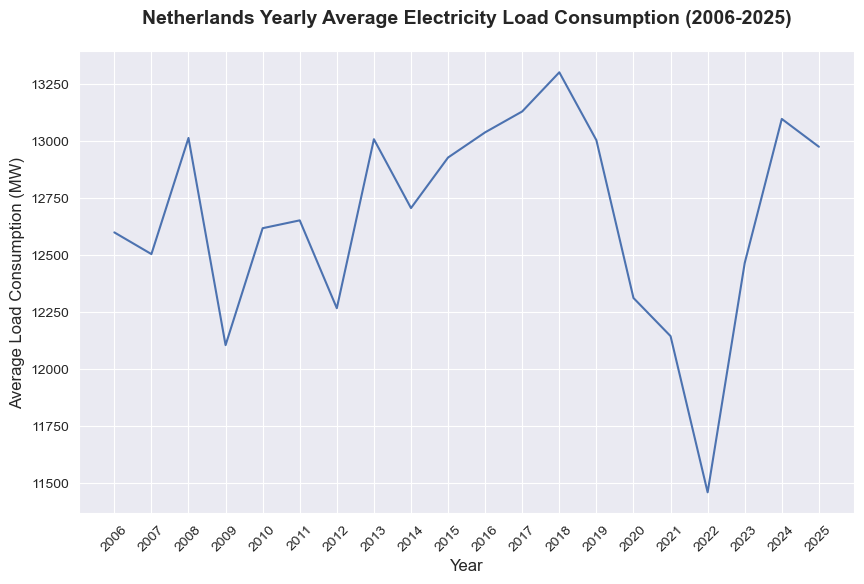

In [9]:
# Aggregate data for yearly trends
yearly_data = data.groupby('Year')['loadConsumption'].mean().reset_index()

# Plot yearly trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_data, x='Year', y='loadConsumption')
plt.title('Netherlands Yearly Average Electricity Load Consumption (2006-2025)', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Load Consumption (MW)', fontsize=12)
plt.xticks(yearly_data['Year'], rotation=45)

plt.savefig("plots/yearly_load_consumption.png", dpi=300, bbox_inches='tight')

plt.show()

The graph shows relatively stable electricity consumption in the Netherlands (2006-2025) with notable drops during the 2009 financial crisis and a dramatic decline in 2022 (lowest at ~11,500 MW), likely due to the COVID-19 pandemic and energy crisis, followed by recovery in 2023-2024.

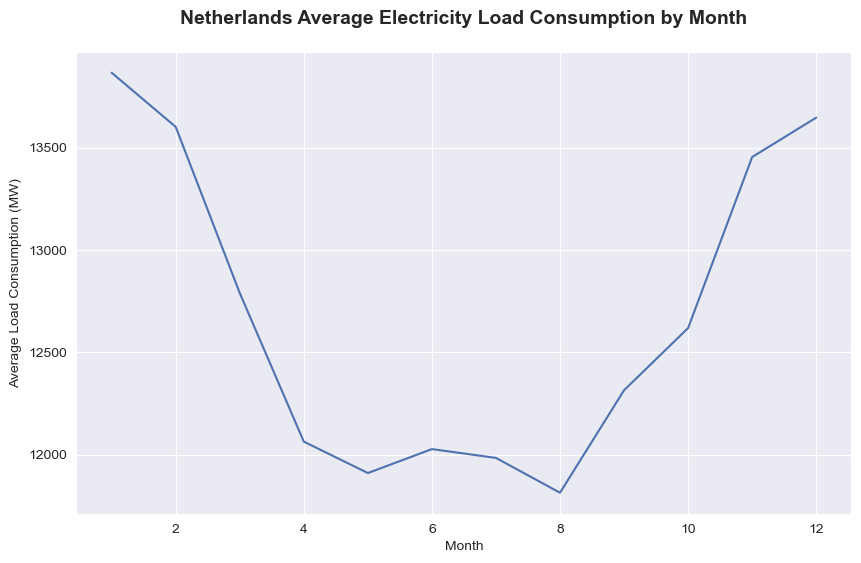

In [11]:
# Monthly patterns by extracting the month
data['Month'] = data['datetime'].dt.month
monthly_data = data.groupby('Month')['loadConsumption'].mean()

# Plot monthly trends
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_data.index, y=monthly_data.values)
plt.title("Netherlands Average Electricity Load Consumption by Month", fontsize=14, pad=20, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Average Load Consumption (MW)")

plt.savefig("plots/avgMonthly_load_consumption.png", dpi=300, bbox_inches='tight')

plt.show()


The monthly pattern shows clear seasonal variation with peak consumption during winter months (December-January at ~13,700 MW) driven by heating demand, and lowest consumption during summer months (May-August at ~12,000 MW) when heating is minimal.

                   mean       median          std
DayOfWeek                                        
Friday     13106.137455  13133.00000  2103.263908
Monday     12973.026212  13128.57125  2286.856835
Saturday   11743.717239  11691.00000  1595.097381
Sunday     11151.423044  11050.05250  1575.456399
Thursday   13239.687707  13388.92750  2186.703218
Tuesday    13194.770018  13341.36875  2170.645381
Wednesday  13231.344341  13361.00000  2185.613771


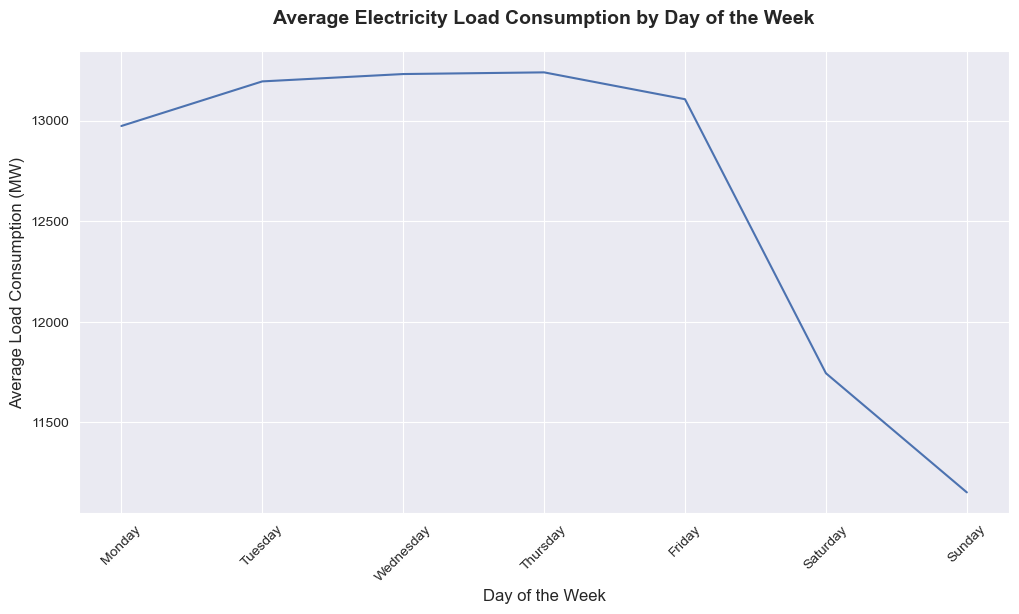

In [14]:
# Create a day of the week column
data['DayOfWeek'] = data['date'].dt.day_name()

# Calculate average consumption per day of week
daily_data = data.groupby('DayOfWeek')['loadConsumption'].agg(['mean', 'median', 'std'])
print(daily_data)

# Define the correct order for days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Visualize with boxplot
daily_mean = data.groupby('DayOfWeek')['loadConsumption'].mean().reindex(day_order)

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(day_order)), y=daily_mean.values)
plt.xticks(range(len(day_order)), day_order, rotation=45)
plt.title('Average Electricity Load Consumption by Day of the Week', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Load Consumption (MW)', fontsize=12)

plt.savefig("plots/daily_consumption_line.png", dpi=300, bbox_inches='tight')
plt.show()

Electricity consumption shows a clear weekly pattern with weekdays (Monday-Friday) 
maintaining relatively stable demand around 13,000-13,100 MW, followed by a sharp 
decline during weekends, particularly on Sunday (~11,200 MW), reflecting reduced industrial and commercial activity.

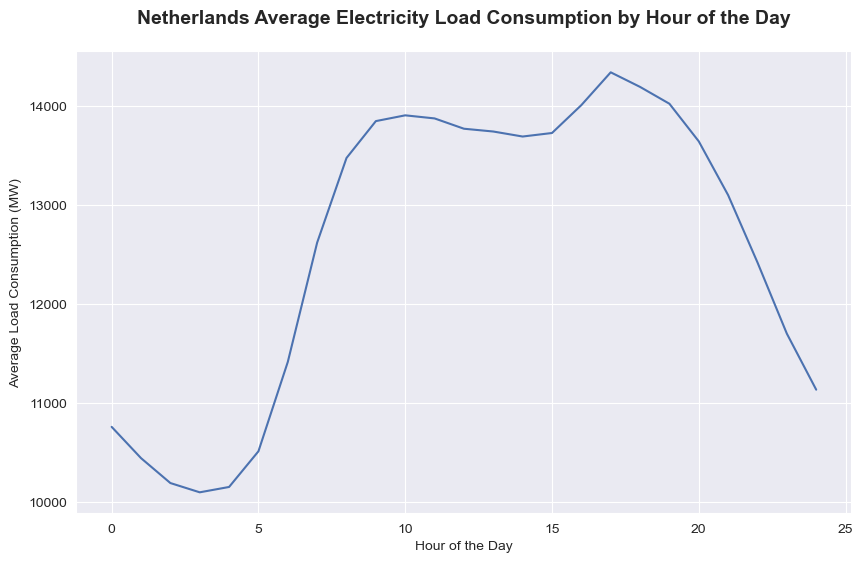

In [15]:
# Hourly patterns
hourly_data = data.groupby('Hour')['loadConsumption'].mean()

# Plot hourly trends
plt.figure(figsize=(10, 6))

sns.lineplot(data=hourly_data.reset_index(), x='Hour', y='loadConsumption')
plt.title("Netherlands Average Electricity Load Consumption by Hour of the Day", fontsize=14, pad=20, fontweight='bold')
plt.xlabel("Hour of the Day")
plt.ylabel("Average Load Consumption (MW)")

plt.savefig("plots/average_hourly_load_consumption.png", dpi=300, bbox_inches='tight')

plt.show()

The hourly pattern shows typical daily electricity demand with lowest consumption during early morning hours (3-4 AM at ~10,100 MW), sharp increases during morning wake-up hours (5-8 AM), sustained high demand throughout the workday (9 AM-6 PM at ~13,900 MW), an evening peak around 6-7 PM (~14,300 MW), and gradual decline through the night as households and businesses wind down.

In [40]:
# Identify outliers using the IQR method
Q1 = data['loadConsumption'].quantile(0.25)
Q3 = data['loadConsumption'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows with outliers
outliers = data[(data['loadConsumption'] < lower_bound) | (data['loadConsumption'] > upper_bound)]

# Display the outliers
outliers

,loadConsumption,date,datetime,Hour,Year,Month
1416,0.0000,2006-03-01,2006-02-28 23:00:00,0,2006,2
2160,0.0000,2006-04-01,2006-03-31 23:00:00,0,2006,3
142808,5443.1750,2022-04-17,2022-04-17 11:00:00,12,2022,4
142809,5383.1850,2022-04-17,2022-04-17 12:00:00,13,2022,4
143312,5644.5375,2022-05-08,2022-05-08 11:00:00,12,2022,5
143313,5632.2950,2022-05-08,2022-05-08 12:00:00,13,2022,5
145496,5528.5600,2022-08-07,2022-08-07 11:00:00,12,2022,8
145497,5533.1850,2022-08-07,2022-08-07 12:00:00,13,2022,8
157188,20059.6425,2023-12-07,2023-12-07 16:00:00,17,2023,12
157189,20019.3050,2023-12-07,2023-12-07 17:00:00,18,2023,12


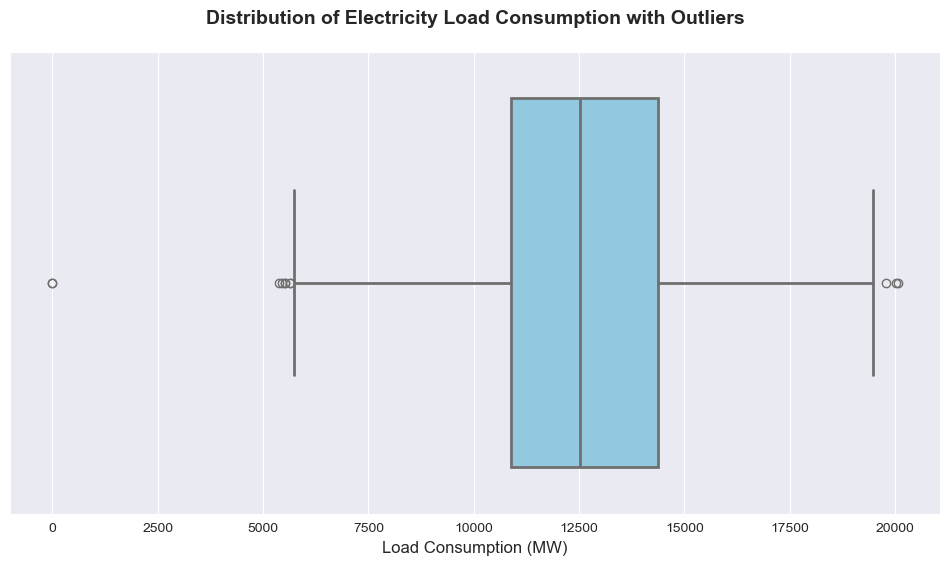

In [42]:
# Check for outliers in the 'loadConsumption' column
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['loadConsumption'], color='skyblue', linewidth=2)
plt.title('Distribution of Electricity Load Consumption with Outliers', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Load Consumption (MW)', fontsize=12)

plt.savefig("plots/load_consumption_boxplot.png", dpi=300, bbox_inches='tight')

plt.show()

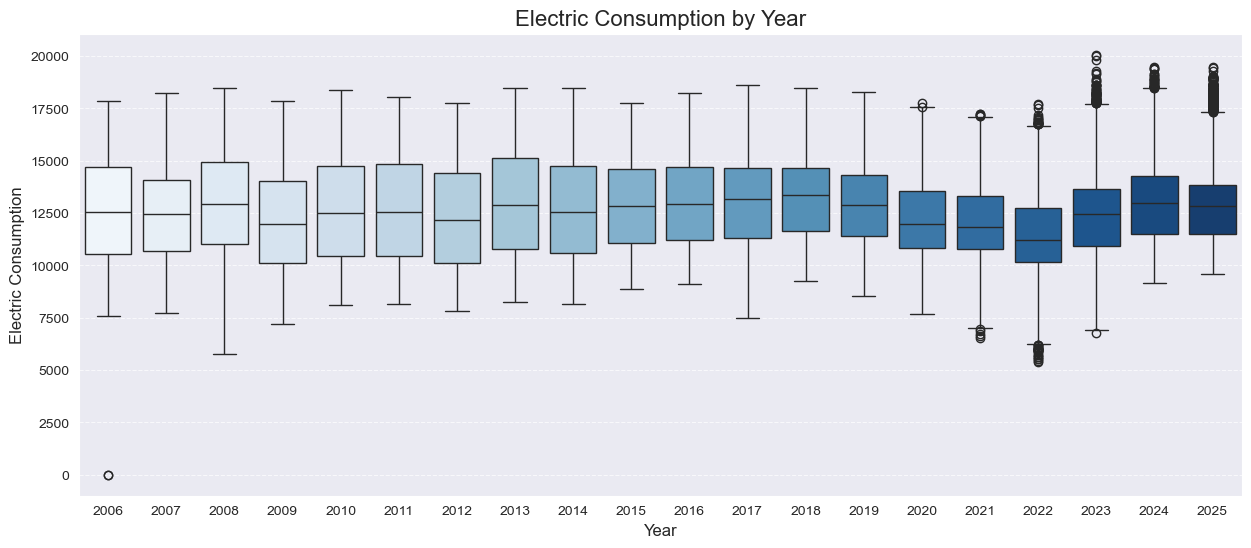

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=data, x='Year', y='loadConsumption', palette='Blues')
ax.set_title('Electric Consumption by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Electric Consumption', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("plots/ElecConsYear.png", dpi=300, bbox_inches='tight')

plt.show()

In [17]:
# Assign seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

# Create a season column
data['Season'] = data['date'].dt.month.map(get_season)  

data.head()

,loadConsumption,date,datetime,Hour,Year,Month,DayOfWeek,Season
0,10215.0,2006-01-01,2005-12-31 23:00:00,0,2006,12,Sunday,Winter
1,9979.0,2006-01-01,2006-01-01 00:00:00,1,2006,1,Sunday,Winter
2,9460.0,2006-01-01,2006-01-01 01:00:00,2,2006,1,Sunday,Winter
3,8833.0,2006-01-01,2006-01-01 02:00:00,3,2006,1,Sunday,Winter
4,8525.0,2006-01-01,2006-01-01 03:00:00,4,2006,1,Sunday,Winter


                mean      median          std       min         max
Season                                                             
Fall    12786.182186  12800.0000  2135.181452  6355.775  19383.0000
Spring  12256.820170  12121.9025  1997.879965     0.000  17547.0000
Summer  11941.153737  11845.0000  1779.569416  5528.560  16688.0000
Winter  13710.085823  13781.0000  2362.329155  5767.000  20059.6425


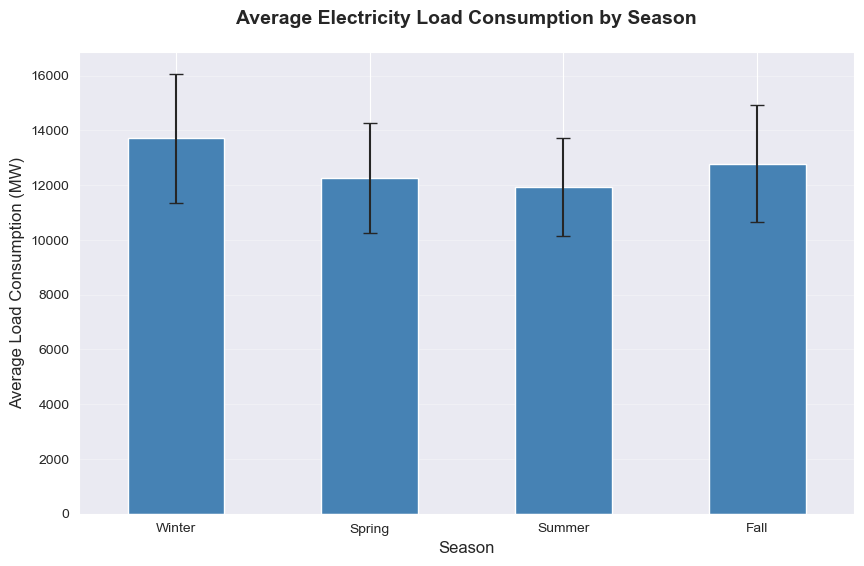

In [18]:
# Calculate average consumption per season
seasonal_data = data.groupby('Season')['loadConsumption'].agg(['mean', 'median', 'std', 'min', 'max'])
print(seasonal_data)

# Alternative: Bar plot with error bars
seasonal_mean = data.groupby('Season')['loadConsumption'].mean()
seasonal_std = data.groupby('Season')['loadConsumption'].std()

plt.figure(figsize=(10, 6))
seasonal_mean.reindex(['Winter', 'Spring', 'Summer', 'Fall']).plot(kind='bar', 
                                                                      color='steelblue', 
                                                                      yerr=seasonal_std.reindex(['Winter', 'Spring', 'Summer', 'Fall']),
                                                                      capsize=5)
plt.title('Average Electricity Load Consumption by Season', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Load Consumption (MW)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.savefig("plots/seasonal_consumption_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
import statsmodels.api as sm
from scipy.stats import shapiro

def check_normality(df, feature):
    plt.figure(figsize=(6, 6))

    # histogram
    plt.hist(df[feature], edgecolor='black', bins=20)
    plt.title(f'Histogram of {feature}')

    # qq plot
    sm.qqplot(df[feature], line='45')
    plt.title(f'QQ plot of {feature}')

    plt.tight_layout()

    plt.show()

    # shapiro wilk
    print(shapiro(df[feature]))


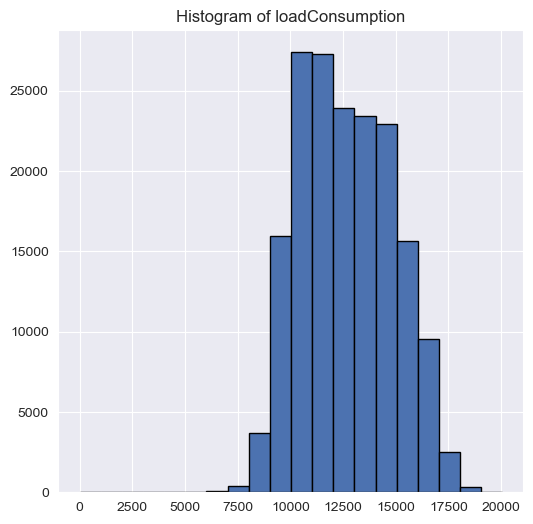

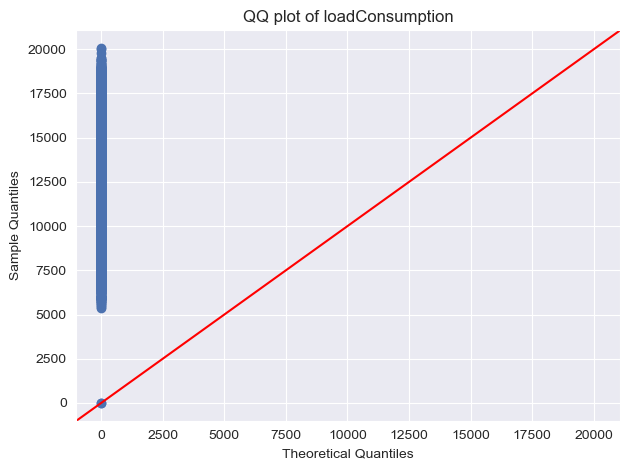

ShapiroResult(statistic=np.float64(0.9825384040199782), pvalue=np.float64(1.3558008370023883e-78))


In [20]:
check_normality(df=data, feature='loadConsumption')

The Shapiro-Wilk test (p-value≈0) confirms that electricity load consumption is not normally distributed, which is also confirmed from the QQ-plot.

### Decomposition of energy load time series

In [ ]:
data.index = data['datetime']
data = data.sort_index()

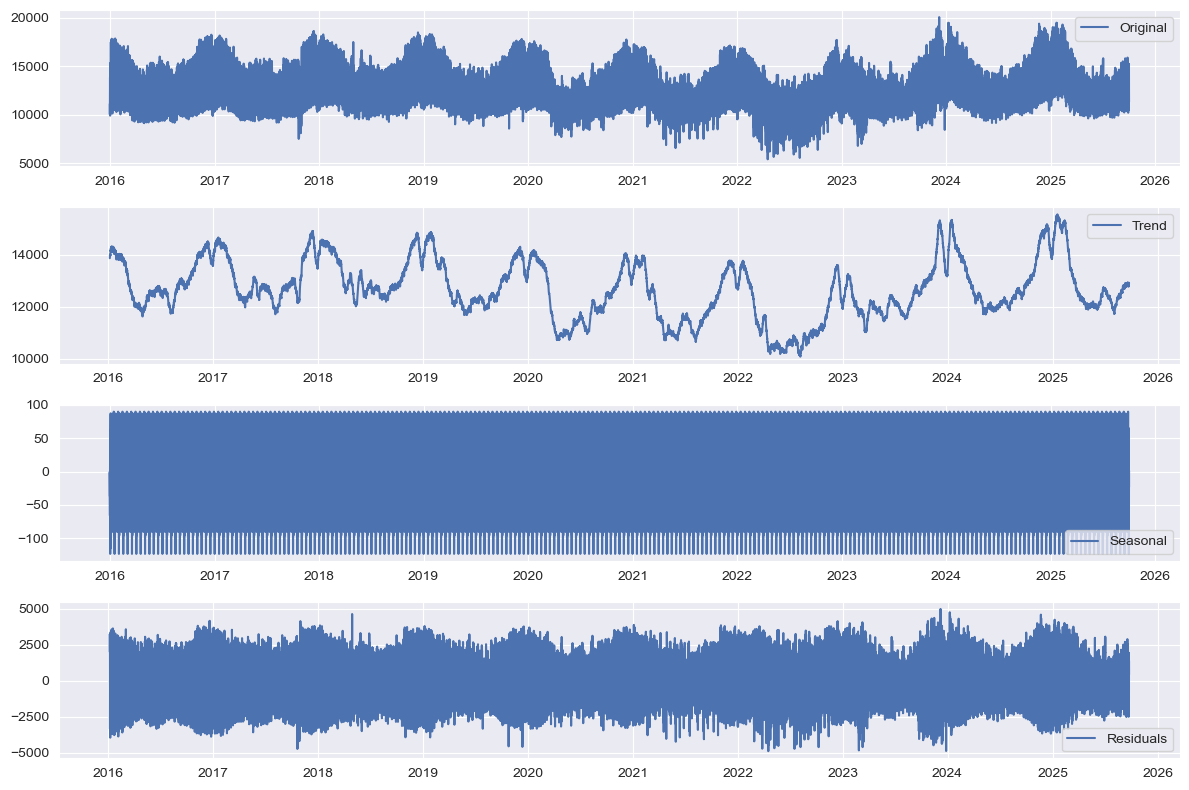

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_decomp = data[data.index.year >= 2016]

# Perform additive decomposition
result = seasonal_decompose(df_decomp['loadConsumption'], model='additive', period=365)

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df_decomp.index, df_decomp['loadConsumption'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.savefig("plots/seasonal_decomposition.png", dpi=300, bbox_inches='tight')
plt.show()

This is a time series decomposition plot of electricity load consumption from 2016 to 2025, breaking down the data into its fundamental components:

Original: The top panel shows the raw hourly electricity load data, displaying high-frequency fluctuations between roughly 5,000-20,000 MW with notable volatility and an apparent decrease in the baseline level around 2020, likely reflecting pandemic-related demand changes.

Trend: The second panel isolates the long-term trend component, revealing a relatively stable pattern oscillating between 10,000-14,500 MW throughout most of the period, with a pronounced dip around 2020-2021 (down to ~10,500 MW) followed by partial recovery, suggesting structural changes in electricity demand patterns during and after the COVID-19 pandemic.

Seasonal: The third panel displays the seasonal component, showing a remarkably consistent pattern with a gradual decline from positive values (around +50-75 MW) to increasingly negative values (reaching approximately -100 MW by 2024-2025), indicating a systematic shift in seasonal electricity consumption patterns over the two decades.

Residuals: The bottom panel presents the residual component (random noise and irregular fluctuations), ranging between approximately -5,000 to +5,000 MW, with the variance appearing relatively stable over time except.

### 2. Weather data

#### KNMI Dataset

|Data                |Granularity |Year range|
|--------------------|------------|----------|
|Weather    |hourl/dailyy      |2006-2025 |

The KNMI dataset contains lots of weather related variables. The column names are abbreviations, which we replace with full names. We select data from 2021 and on because that is the start date of our research. We cast some columns to the right format.

We choose these predictors from the dataset

In [21]:
def read_data(path: str) -> pd.DataFrame:
    """
    Read the data.
    Strip spaces from the columns.
    Rename all the columns (abbreviations -> full names).
    """

    weather = pd.read_csv(path)

    weather.columns = weather.columns.str.strip()
    weather = weather.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    weather.replace('', None, inplace=True)

    column_mapping = {
        'YYYYMMDD': 'Date',
        'RH': 'DailyPrecipitation',
        'RHX': 'MaxHourlyPrecipitation',
        'RHXH': 'HDMaxPrecipitation',
        'TG': 'DailyMeanTemperature',
        'TN': 'HourlyMinTemperature',
        'TNH': 'HDMinTemperature',
        'TX': 'HourlyMaxTemperature',
        'TXH': 'HDMaxTemperature',
        'FG': 'DailyMeanWindspeed',
        'FHX': 'MaxHourlyMeanWindspeed',
        'FHXH': 'HDMaxMeanWindspeed',
        'FHN': 'MinHourlyMeanWindspeed',
        'FHNH': 'HDMinMeanWindspeed'
    }

    weather = weather[column_mapping.keys()]
    weather.rename(columns=column_mapping, inplace=True)

    return weather


def filter_on_year(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Filter on only 1995 and later and reset index after filtering.
    """
    weather = weather[weather['Date'] >= 19950101]
    weather.reset_index(drop=True, inplace=True)

    return weather


def cast_datekey(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast datekey 19950101 to format 1995/01/01
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y%m%d').dt.strftime('%Y/%m/%d')

    return weather


def cast_hour_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast hour columns to integer.
    """
    hour_cols = [
        'HDMaxPrecipitation',
        'HDMinTemperature',
        'HDMaxTemperature',
        'HDMaxMeanWindspeed',
        'HDMinMeanWindspeed'
    ]

    for i in hour_cols:
        weather[i] = weather[i].astype(int)

    return weather


def convert_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Divide the following columns by 10 to get actual number, since they are 0.1 of the actual number.
    """
    cols_to_convert = [
        'DailyPrecipitation',
        'MaxHourlyPrecipitation',
        'DailyMeanTemperature',
        'HourlyMaxTemperature',
        'DailyMeanWindspeed',
        'MinHourlyMeanWindspeed',
        'MaxHourlyMeanWindspeed'
    ]
    for i in cols_to_convert:
        weather[i] = weather[i] / 10

    return weather


def create_date_columns(weather: pd.DataFrame) -> pd.DataFrame:
    """
    Cast date column (2021-01-01 instead of 2021/01/01) and add month and year columns
    Create a week key combining year and week number
    """
    weather['Date'] = pd.to_datetime(weather['Date'], format='%Y/%m/%d')
    weather['Month'] = weather['Date'].dt.month
    weather['Year'] = weather['Date'].dt.year
    weather['Week'] = weather['Date'].dt.isocalendar().week

    weather['WeekKey'] = weather['Year'].astype(str) + weather['Week'].apply(lambda x: '{:02d}'.format(x))
    weather['day_of_week'] = weather['Date'].dt.day_name()

    return weather


def preprocess_weather(path: str) -> pd.DataFrame:
    """
    Preprocess the weather data.
    """
    weather = read_data(path)
    weather = filter_on_year(weather)
    weather = cast_datekey(weather)
    weather = cast_hour_columns(weather)
    weather = convert_columns(weather)
    weather = create_date_columns(weather)

    return weather

In [22]:
weather_path = 'raw_data/deBilt.csv'

weather = preprocess_weather(weather_path)

weather

,Date,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,1995-01-01,8.3,1.7,12,2.0,2,14,3.8,19,4.6,7.7,20,2.6,1,1,1995,52,199552,Sunday
1,1995-01-02,3.2,1.2,4,3.0,-12,24,5.9,12,4.6,7.7,7,1.0,24,1,1995,1,199501,Monday
2,1995-01-03,-0.1,-0.1,3,-0.5,-38,24,2.3,14,2.1,3.1,12,1.0,1,1,1995,1,199501,Tuesday
3,1995-01-04,0.0,0.0,1,-2.8,-48,21,0.3,14,2.6,4.1,14,2.1,1,1,1995,1,199501,Wednesday
4,1995-01-05,0.0,0.0,1,-3.9,-59,8,-1.8,14,5.7,7.7,21,3.1,1,1,1995,1,199501,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10968,2025-01-11,-0.1,-0.1,1,0.5,-45,8,5.8,14,1.5,3.0,14,0.0,7,1,2025,2,202502,Saturday
10969,2025-01-12,0.1,0.1,21,1.7,-6,22,6.0,14,1.2,2.0,5,1.0,1,1,2025,2,202502,Sunday
10970,2025-01-13,0.0,0.0,1,0.5,-33,5,5.2,14,2.2,4.0,13,1.0,1,1,2025,3,202503,Monday
10971,2025-01-14,0.1,0.1,20,2.8,-16,1,5.7,24,3.1,5.0,13,2.0,6,1,2025,3,202503,Tuesday


In [39]:
print("\n=== Daily Precipitation Summary Statistics ===\n")
print(weather['DailyPrecipitation'].describe())

print("\n=== Daily Temperature Summary Statistics ===\n")
print(weather['DailyMeanTemperature'].describe())

print("\n=== Daily Wind Speed Summary Statistics ===\n")
print(weather['DailyMeanWindspeed'].describe())


=== Daily Precipitation Summary Statistics ===

count     10973.0
unique      292.0
top           0.0
freq       3906.0
Name: DailyPrecipitation, dtype: float64

=== Daily Temperature Summary Statistics ===

count    10973.000000
mean        10.733227
std          6.237881
min        -12.600000
25%          6.300000
50%         10.700000
75%         15.700000
max         29.700000
Name: DailyMeanTemperature, dtype: float64

=== Daily Wind Speed Summary Statistics ===

count     10973.0
unique       96.0
top           2.8
freq        416.0
Name: DailyMeanWindspeed, dtype: float64


In [23]:
weather.isna().sum() / len(weather)

Date                      0.0
DailyPrecipitation        0.0
MaxHourlyPrecipitation    0.0
HDMaxPrecipitation        0.0
DailyMeanTemperature      0.0
HourlyMinTemperature      0.0
HDMinTemperature          0.0
HourlyMaxTemperature      0.0
HDMaxTemperature          0.0
DailyMeanWindspeed        0.0
MaxHourlyMeanWindspeed    0.0
HDMaxMeanWindspeed        0.0
MinHourlyMeanWindspeed    0.0
HDMinMeanWindspeed        0.0
Month                     0.0
Year                      0.0
Week                      0.0
WeekKey                   0.0
day_of_week               0.0
dtype: float64

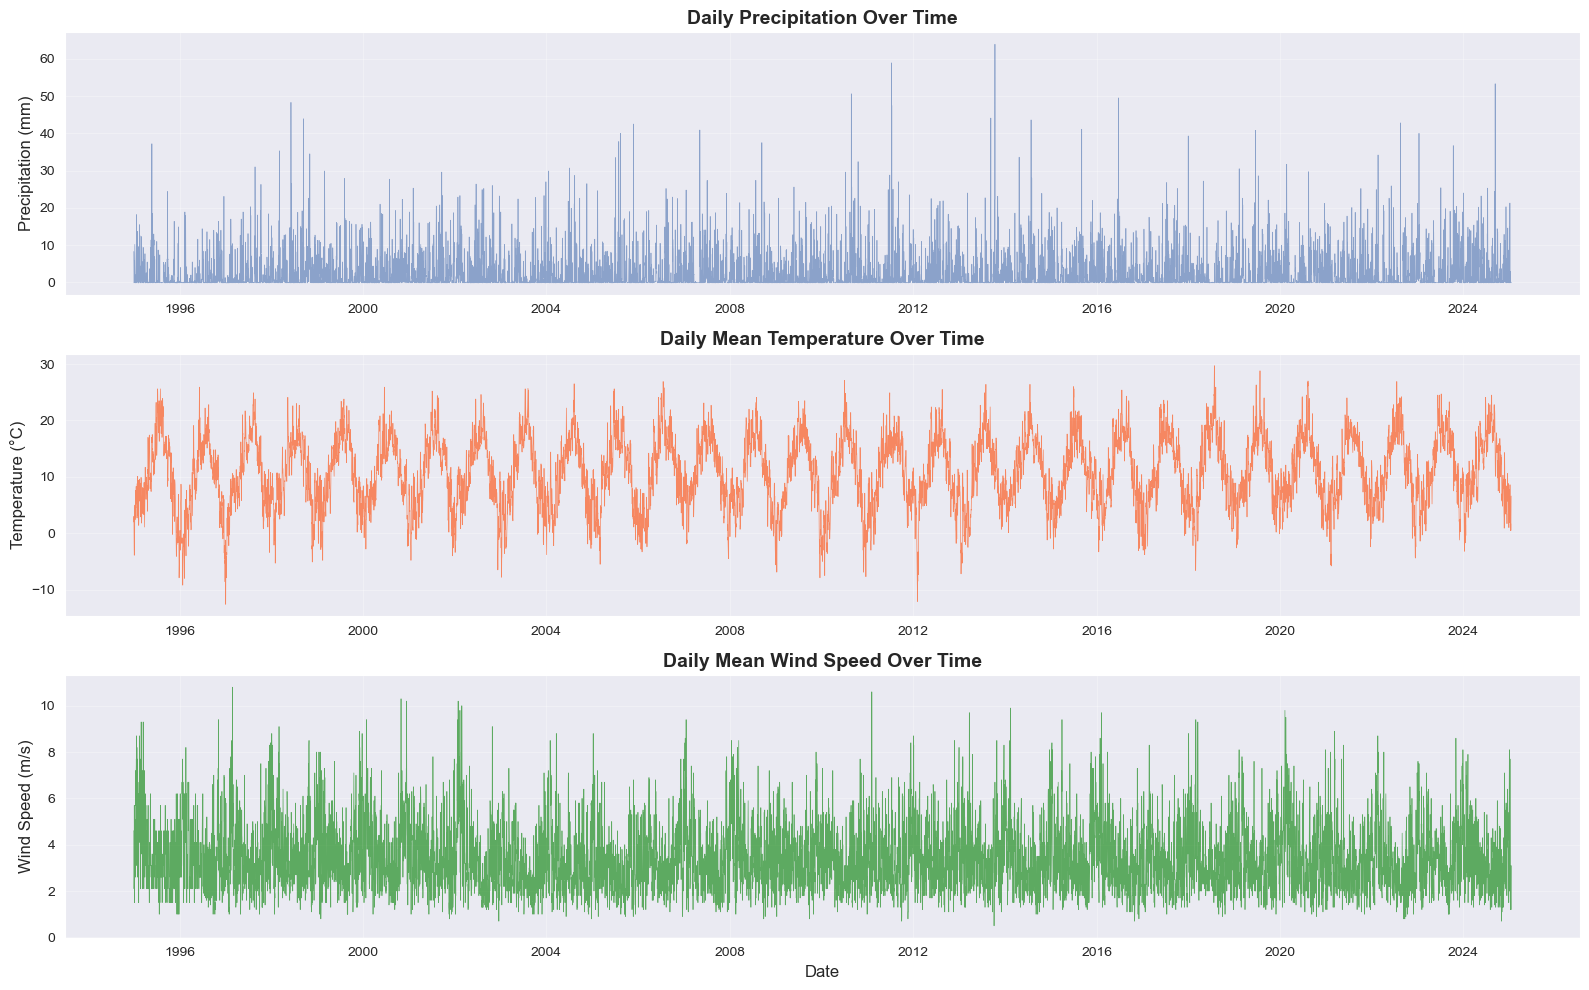

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Precipitation
axes[0].plot(weather['Date'], weather['DailyPrecipitation'], alpha=0.6, linewidth=0.5)
axes[0].set_title('Daily Precipitation Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precipitation (mm)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Temperature
axes[1].plot(weather['Date'], weather['DailyMeanTemperature'], alpha=0.6, linewidth=0.5, color='orangered')
axes[1].set_title('Daily Mean Temperature Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Temperature (°C)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Wind Speed
axes[2].plot(weather['Date'], weather['DailyMeanWindspeed'], alpha=0.6, linewidth=0.5, color='green')
axes[2].set_title('Daily Mean Wind Speed Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Wind Speed (m/s)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plots/weather_timeseries.png", dpi=300, bbox_inches='tight')
plt.show()

Daily weather data from 1995-2025 shows highly variable precipitation with occasional extreme events reaching 60mm, strong seasonal temperature cycles oscillating between -10°C and 30°C, and relatively consistent wind speeds averaging 2-10 m/s with sporadic peaks. The temperature plot clearly reveals annual periodicity, while precipitation and wind speed exhibit more stochastic day-to-day variability without obvious long-term trends.

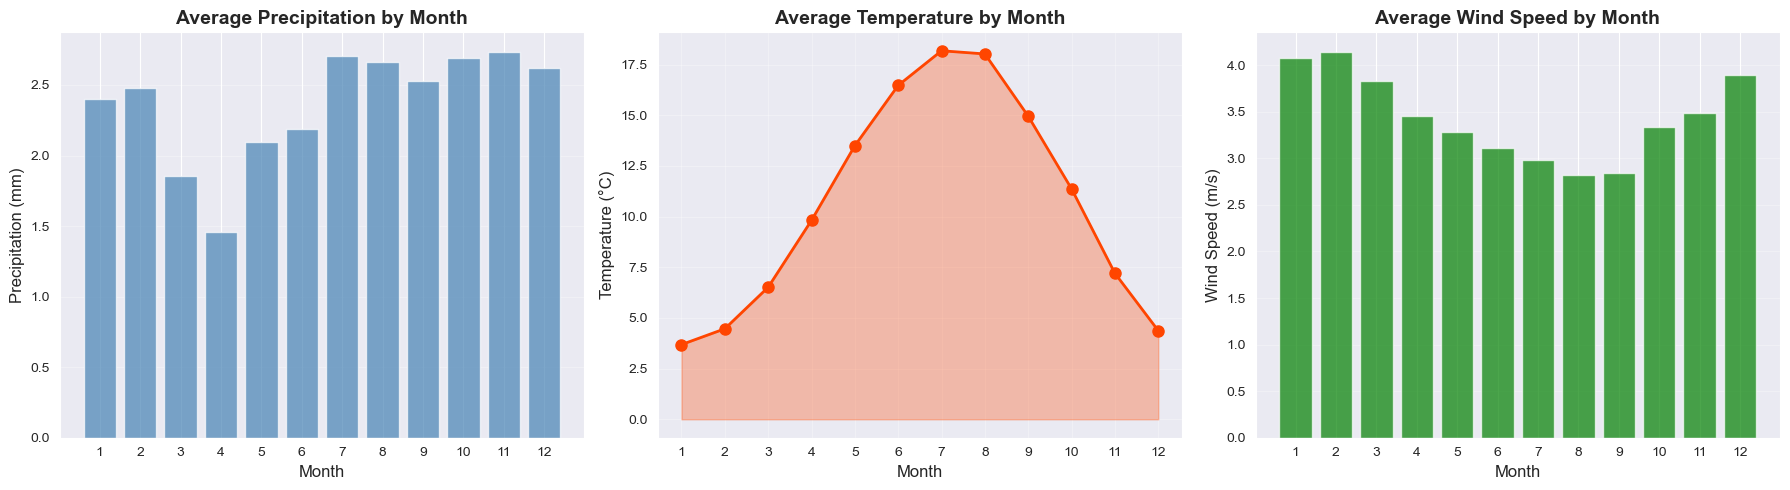

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Monthly precipitation
monthly_precip = weather.groupby('Month')['DailyPrecipitation'].mean()
axes[0].bar(monthly_precip.index, monthly_precip.values, color='steelblue', alpha=0.7)
axes[0].set_title('Average Precipitation by Month', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Precipitation (mm)', fontsize=12)
axes[0].set_xticks(range(1, 13))
axes[0].grid(True, alpha=0.3, axis='y')

# Monthly temperature
monthly_temp = weather.groupby('Month')['DailyMeanTemperature'].mean()
axes[1].plot(monthly_temp.index, monthly_temp.values, marker='o', linewidth=2, markersize=8, color='orangered')
axes[1].fill_between(monthly_temp.index, monthly_temp.values, alpha=0.3, color='orangered')
axes[1].set_title('Average Temperature by Month', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Temperature (°C)', fontsize=12)
axes[1].set_xticks(range(1, 13))
axes[1].grid(True, alpha=0.3)

# Monthly wind speed
monthly_wind = weather.groupby('Month')['DailyMeanWindspeed'].mean()
axes[2].bar(monthly_wind.index, monthly_wind.values, color='green', alpha=0.7)
axes[2].set_title('Average Wind Speed by Month', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Month', fontsize=12)
axes[2].set_ylabel('Wind Speed (m/s)', fontsize=12)
axes[2].set_xticks(range(1, 13))
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("plots/weather_monthly_patterns.png", dpi=300, bbox_inches='tight')
plt.show()

Monthly weather patterns reveal distinct seasonal cycles: precipitation remains relatively stable year-round (1.5-2.7mm daily average), temperature shows a clear summer peak reaching ~18°C in July-August and winter low of ~4°C in January, and wind speed is highest in winter months (January-February at ~4 m/s) and lowest in summer (August-September at ~2.8 m/s).

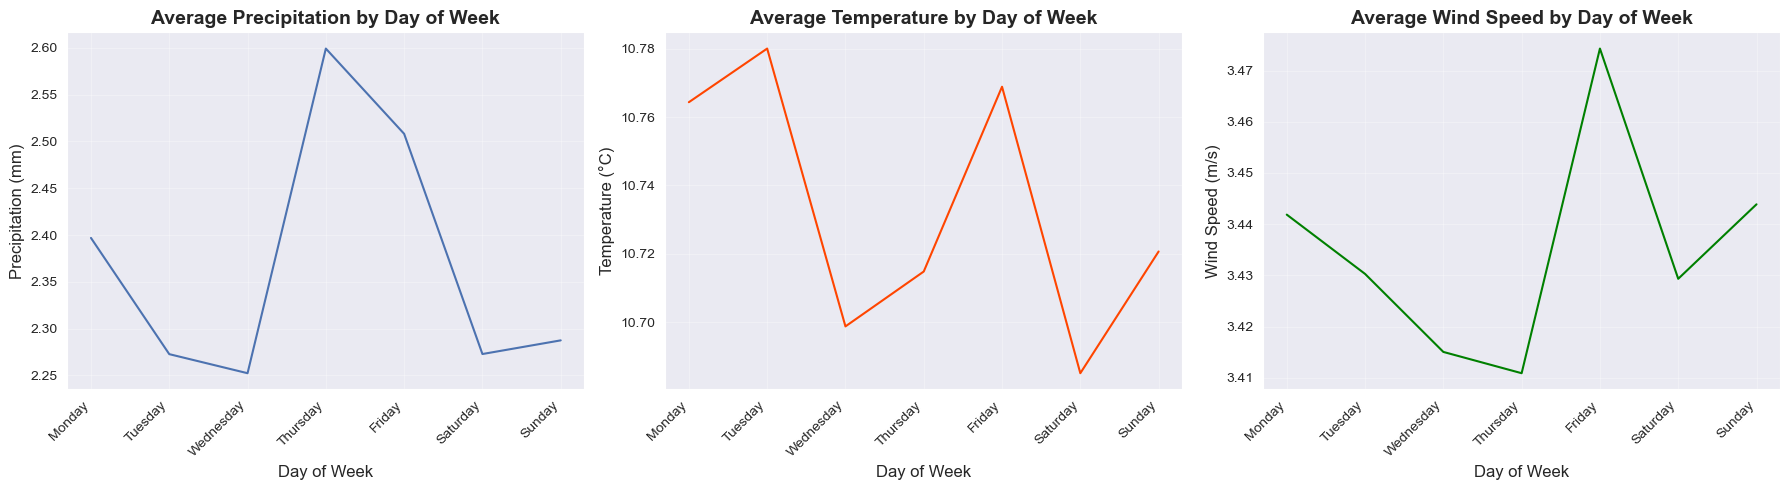

In [30]:
# 3. Day of Week Patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# By day of week - Precipitation
dow_precip = weather.groupby('day_of_week')['DailyPrecipitation'].mean()
axes[0].plot(range(7), dow_precip.values)
axes[0].set_title('Average Precipitation by Day of Week', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day of Week', fontsize=12)
axes[0].set_ylabel('Precipitation (mm)', fontsize=12)
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_names, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3)

# By day of week - Temperature
dow_temp = weather.groupby('day_of_week')['DailyMeanTemperature'].mean()
axes[1].plot(range(7), dow_temp.values, color='orangered')
axes[1].set_title('Average Temperature by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week', fontsize=12)
axes[1].set_ylabel('Temperature (°C)', fontsize=12)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

# By day of week - Wind Speed
dow_wind = weather.groupby('day_of_week')['DailyMeanWindspeed'].mean()
axes[2].plot(range(7), dow_wind.values, color='green')
axes[2].set_title('Average Wind Speed by Day of Week', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Day of Week', fontsize=12)
axes[2].set_ylabel('Wind Speed (m/s)', fontsize=12)
axes[2].set_xticks(range(7))
axes[2].set_xticklabels(day_names, rotation=45, ha='right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plots/weather_day_of_week.png", dpi=300, bbox_inches='tight')
plt.show()

Weekly patterns show minimal variation across all three variables: precipitation peaks slightly on Thursday (~2.6mm), temperature fluctuates marginally between 10.69-10.78°C with a Tuesday high, and wind speed varies only between 3.41-3.47 m/s with a Friday peak, indicating that day of the week has negligible influence on weather conditions.

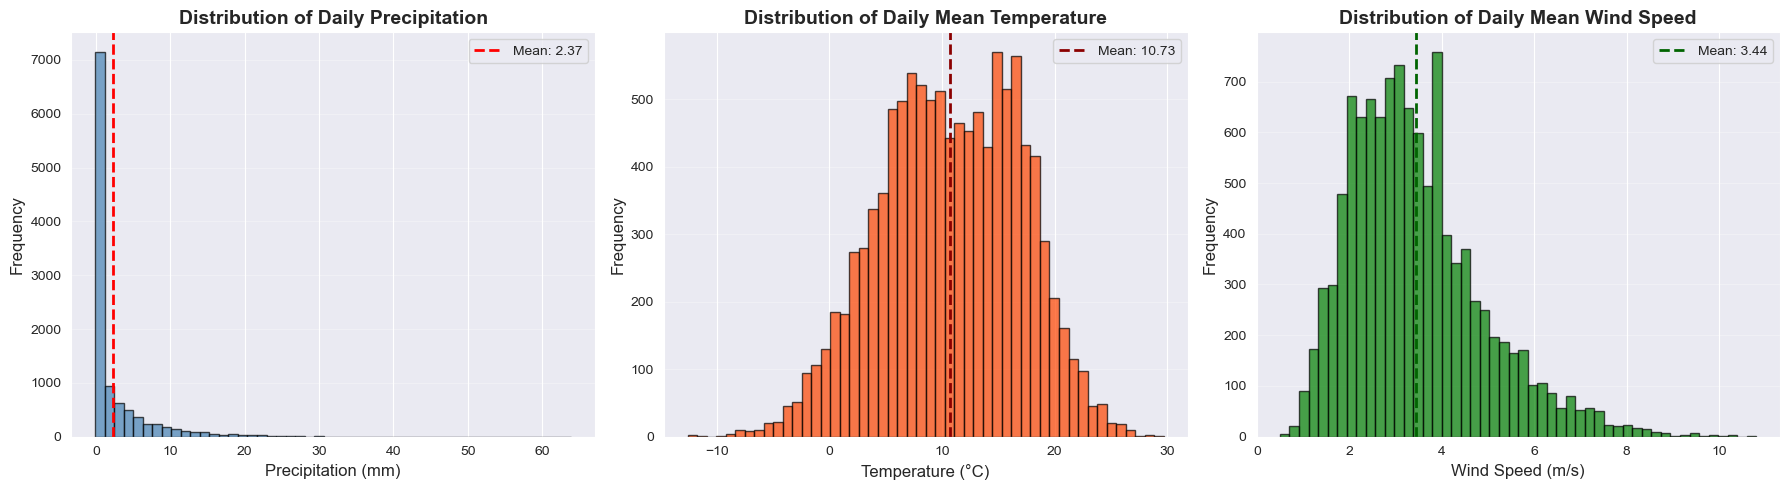

In [31]:
# 4. Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precipitation distribution
axes[0].hist(weather['DailyPrecipitation'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_title('Distribution of Daily Precipitation', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Precipitation (mm)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axvline(weather['DailyPrecipitation'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {weather["DailyPrecipitation"].mean():.2f}')
axes[0].legend()

# Temperature distribution
axes[1].hist(weather['DailyMeanTemperature'], bins=50, alpha=0.7, color='orangered', edgecolor='black')
axes[1].set_title('Distribution of Daily Mean Temperature', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Temperature (°C)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axvline(weather['DailyMeanTemperature'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {weather["DailyMeanTemperature"].mean():.2f}')
axes[1].legend()

# Wind Speed distribution
axes[2].hist(weather['DailyMeanWindspeed'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[2].set_title('Distribution of Daily Mean Wind Speed', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Wind Speed (m/s)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].axvline(weather['DailyMeanWindspeed'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {weather["DailyMeanWindspeed"].mean():.2f}')
axes[2].legend()

plt.tight_layout()
plt.savefig("plots/weather_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

The distributions reveal distinct characteristics for each weather variable: precipitation shows a heavily right-skewed distribution with over 7,000 days having minimal rainfall (near 0mm) and a mean of 2.37mm, indicating most days are dry with occasional wet events; temperature follows an approximately normal distribution centered at 10.73°C ranging from -10°C to 30°C, reflecting the temperate maritime climate; and wind speed displays a slightly right-skewed normal distribution with mean 3.44 m/s, predominantly ranging between 2-6 m/s with rare extreme wind events exceeding 8 m/s.

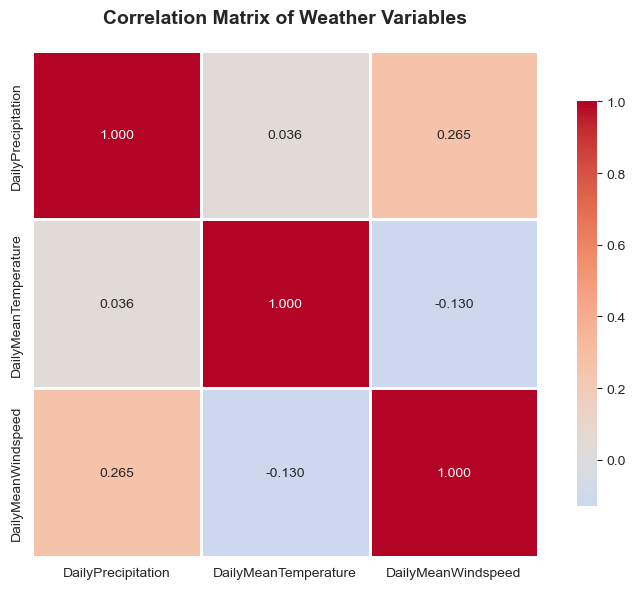

In [34]:
# 7. Correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))
corr_matrix = weather[['DailyPrecipitation', 'DailyMeanTemperature', 'DailyMeanWindspeed']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax, fmt='.3f')
ax.set_title('Correlation Matrix of Weather Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig("plots/weather_correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

The correlation matrix reveals weak to moderate relationships between weather variables: precipitation shows a weak positive correlation with wind speed (0.265), suggesting slightly windier conditions during rainy days, but is essentially uncorrelated with temperature (0.036); notably, temperature and wind speed exhibit a weak negative correlation (-0.130), indicating that warmer days tend to be slightly calmer, which aligns with seasonal patterns where winter brings both colder temperatures and stronger winds.

## 3. Economical Data

### Energy Prices

Analysis of energy prices provided by CBS. The energy prices are recorded per semester and are separated depending the consumption in MWh. Data exist from 1st semester of 2009 till 1st semester of 2025.



In [41]:
energyPrice_path = 'raw_data/Prices_of_electricity.csv'
energyPriceNl = pd.read_csv(energyPrice_path, delimiter=';')


In [44]:
energyPriceNl.head()

,Periods,Price components,Electricity price|Consumption bands households|Less than 1 MWh,"Electricity price|Consumption bands households|1 until 2,5 MWh","Electricity price|Consumption bands households|2,5 until 5 MWh",Electricity price|Consumption bands households|5 until 15 MWh,Electricity price|Consumption bands households|15 MWh and higher,Electricity price|Consumption bands non-households|Less than 20 MWh,Electricity price|Consumption bands non-households|20 unitl 500 MWh,Electricity price|Consumption bands non-households|500 until 2 000 MWh,Electricity price|Consumption bands non-households|2 000 until 20 000 MWh,Electricity price|Consumption bands non-households|20 000 until 70 000 MWh,Electricity price|Consumption bands non-households|70 000 until 150 000 MWh,Electricity price|Consumption bands non-households|150 000 MWh and higher
0,2009 1st semester,Total price,-0.025,0.184,0.213,0.224,0.223,0.293,0.210,0.141,0.122,0.102,0.100,0.075
1,2009 2nd semester,Total price,-0.043,0.174,0.204,0.217,0.170,0.292,0.170,0.136,0.120,0.093,0.090,0.067
2,2009,Total price,-0.034,0.179,0.209,0.221,0.197,0.292,0.190,0.138,0.121,0.098,0.094,0.071
3,2010 1st semester,Total price,-0.094,0.147,0.185,0.202,0.198,0.274,0.192,0.126,0.107,0.084,0.082,0.069
4,2010 2nd semester,Total price,-0.088,0.150,0.186,0.202,0.148,0.261,0.151,0.121,0.107,0.078,0.081,0.071


In [47]:
# Assuming your dataframe is called energyPriceNl
# First, let's filter out rows that only have year (no semester info)
# Keep only rows where 'Periods' contains 'semester'
energyPriceNl_clean = energyPriceNl[energyPriceNl['Periods'].str.contains('semester', case=False, na=False)].copy()

# Reset index
energyPriceNl_clean.reset_index(drop=True, inplace=True)
energyPriceNl_clean.head()

,Periods,Price components,Electricity price|Consumption bands households|Less than 1 MWh,"Electricity price|Consumption bands households|1 until 2,5 MWh","Electricity price|Consumption bands households|2,5 until 5 MWh",Electricity price|Consumption bands households|5 until 15 MWh,Electricity price|Consumption bands households|15 MWh and higher,Electricity price|Consumption bands non-households|Less than 20 MWh,Electricity price|Consumption bands non-households|20 unitl 500 MWh,Electricity price|Consumption bands non-households|500 until 2 000 MWh,Electricity price|Consumption bands non-households|2 000 until 20 000 MWh,Electricity price|Consumption bands non-households|20 000 until 70 000 MWh,Electricity price|Consumption bands non-households|70 000 until 150 000 MWh,Electricity price|Consumption bands non-households|150 000 MWh and higher
0,2009 1st semester,Total price,-0.025,0.184,0.213,0.224,0.223,0.293,0.210,0.141,0.122,0.102,0.100,0.075
1,2009 2nd semester,Total price,-0.043,0.174,0.204,0.217,0.170,0.292,0.170,0.136,0.120,0.093,0.090,0.067
2,2010 1st semester,Total price,-0.094,0.147,0.185,0.202,0.198,0.274,0.192,0.126,0.107,0.084,0.082,0.069
3,2010 2nd semester,Total price,-0.088,0.150,0.186,0.202,0.148,0.261,0.151,0.121,0.107,0.078,0.081,0.071
4,2011 1st semester,Total price,-0.108,0.141,0.180,0.198,0.196,0.243,0.180,0.121,0.103,0.080,0.080,0.070


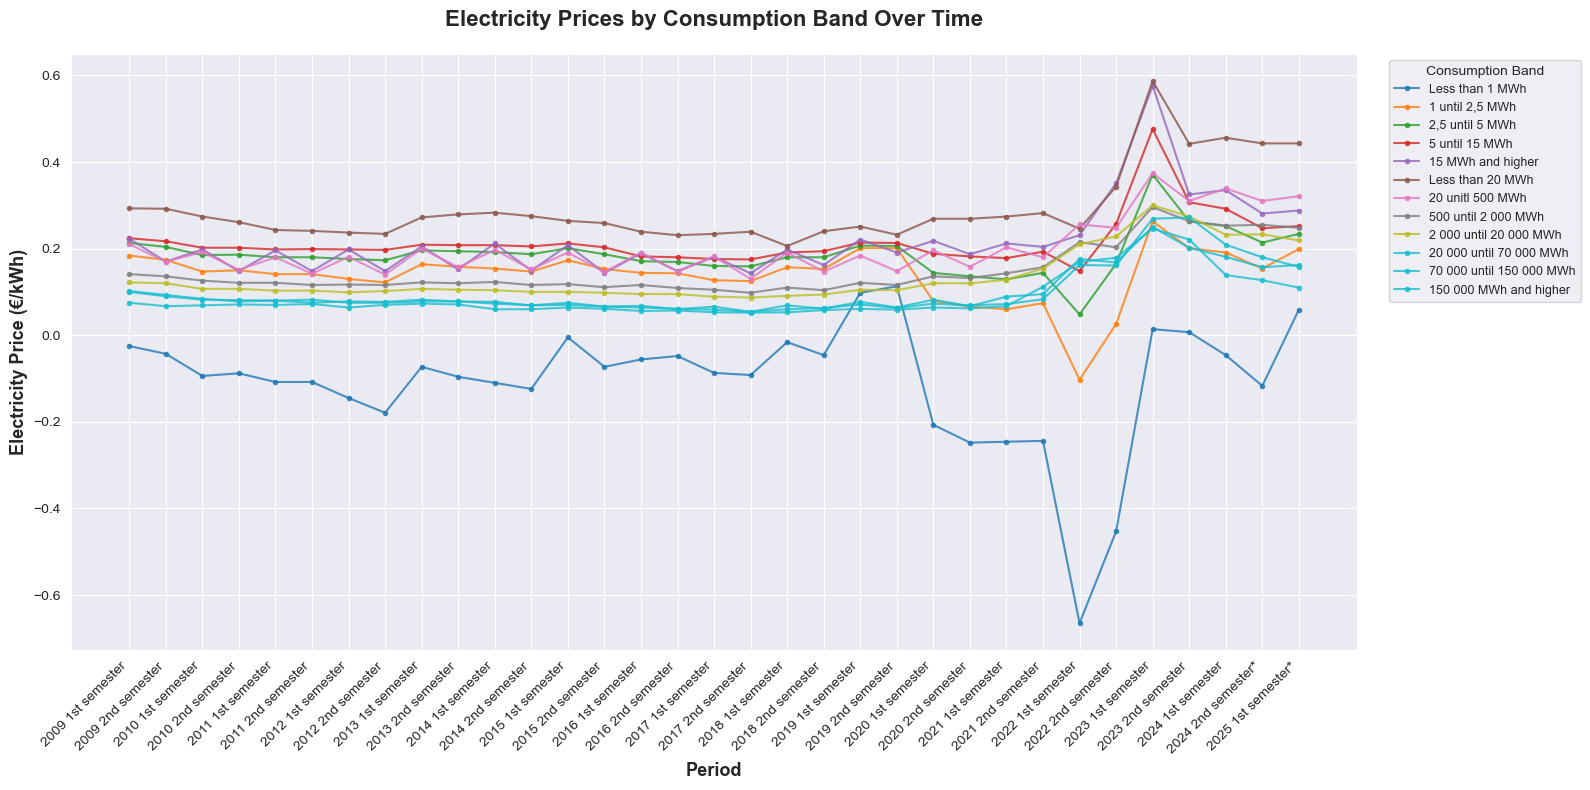

In [54]:
plt.figure(figsize=(16, 8))

# Get the consumption band columns (excluding 'Periods' and 'Price components')
consumption_cols = [col for col in energyPriceNl_clean.columns 
                   if col not in ['Periods', 'Price components']]

# Create x-axis labels from periods
x_labels = energyPriceNl_clean['Periods']
x_positions = range(len(x_labels))

# Plot each consumption band with shortened labels
colors = plt.cm.tab10(range(len(consumption_cols)))
for i, col in enumerate(consumption_cols):
    # Extract text after the last '|'
    label = col.split('|')[-1] if '|' in col else col
    
    plt.plot(x_positions, energyPriceNl_clean[col], 
            marker='o', markersize=3, 
            label=label, alpha=0.8, color=colors[i])

# Customize the plot
plt.xlabel('Period', fontsize=13, fontweight='bold')
plt.ylabel('Electricity Price (€/kWh)', fontsize=13, fontweight='bold')
plt.title('Electricity Prices by Consumption Band Over Time', 
         fontsize=16, fontweight='bold', pad=20)

# Set x-axis ticks and labels
plt.xticks(x_positions, x_labels, rotation=45, ha='right')

# Add legend with smaller font and better positioning
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', 
          frameon=True, fontsize=9, title='Consumption Band', title_fontsize=10)

plt.tight_layout()
plt.savefig("plots/energy_prices_all_bands.png", dpi=300, bbox_inches='tight')
plt.show()

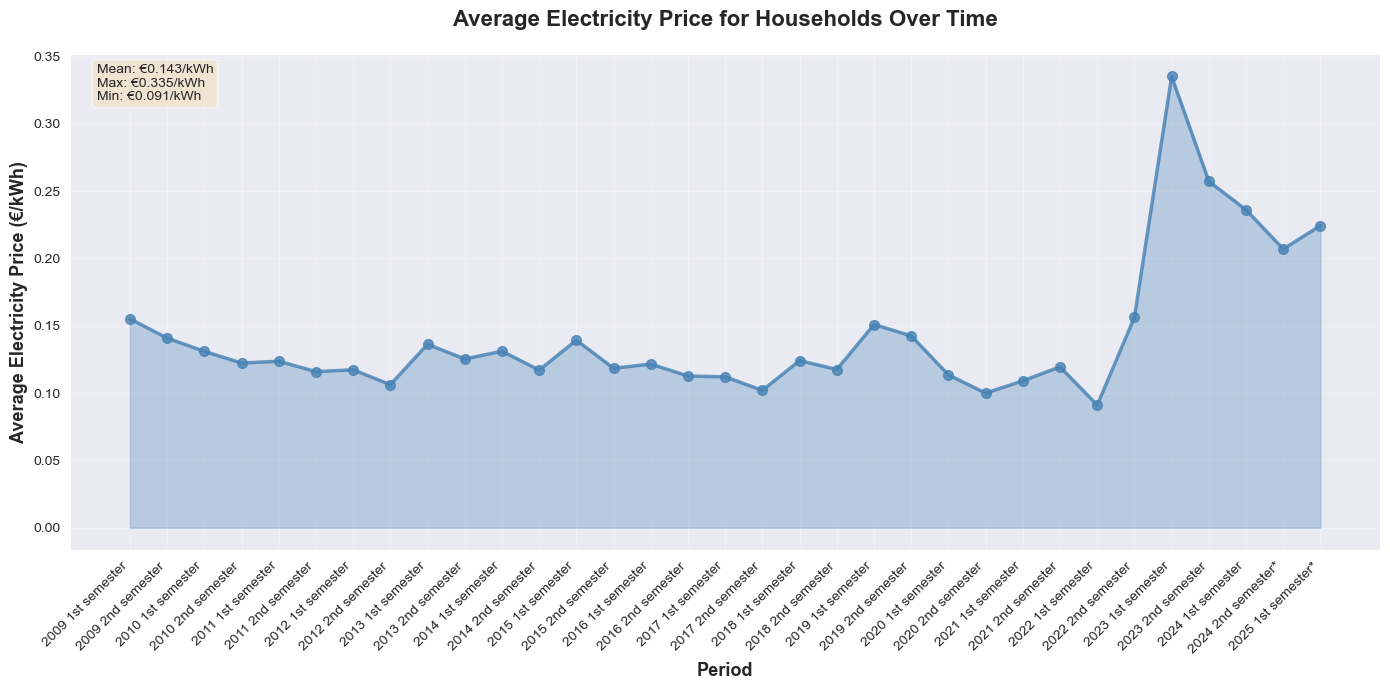

In [57]:
# Calculate average price across household consumption bands
energyPriceNl_clean['Average_Household_Price'] = energyPriceNl_clean[consumption_cols].mean(axis=1)

# Create the plot
plt.figure(figsize=(14, 7))

# Create x-axis
x_labels = energyPriceNl_clean['Periods']
x_positions = range(len(x_labels))

# Plot the average
plt.plot(x_positions, energyPriceNl_clean['Average_Household_Price'], 
         marker='o', linewidth=2.5, markersize=7, 
         color='steelblue', alpha=0.8, label='Average Household Price')

# Fill area under the curve
plt.fill_between(x_positions, energyPriceNl_clean['Average_Household_Price'], 
                 alpha=0.3, color='steelblue')

# Customize the plot
plt.xlabel('Period', fontsize=13, fontweight='bold')
plt.ylabel('Average Electricity Price (€/kWh)', fontsize=13, fontweight='bold')
plt.title('Average Electricity Price for Households Over Time', 
         fontsize=16, fontweight='bold', pad=20)

# Set x-axis ticks and labels
plt.xticks(x_positions, x_labels, rotation=45, ha='right')

# Add grid
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.set_axisbelow(True)

# Add some statistics as text
mean_price = energyPriceNl_clean['Average_Household_Price'].mean()
max_price = energyPriceNl_clean['Average_Household_Price'].max()
min_price = energyPriceNl_clean['Average_Household_Price'].min()

textstr = f'Mean: €{mean_price:.3f}/kWh\nMax: €{max_price:.3f}/kWh\nMin: €{min_price:.3f}/kWh'
plt.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig("plots/energy_prices_household_average.png", dpi=300, bbox_inches='tight')
plt.show()

In [59]:
# Print summary
print("\n=== Average Household Electricity Price Statistics ===")
print(f"\nMean: €{mean_price:.3f}/kWh")
print(f"Max: €{max_price:.3f}/kWh (Period: {x_labels[energyPriceNl_clean['Average_Household_Price'].idxmax()]})")
print(f"Min: €{min_price:.3f}/kWh (Period: {x_labels[energyPriceNl_clean['Average_Household_Price'].idxmin()]})")


=== Average Household Electricity Price Statistics ===

Mean: €0.143/kWh
Max: €0.335/kWh (Period: 2023 1st semester)
Min: €0.091/kWh (Period: 2022 1st semester)


## GDP

In [ ]:
DP_path = 'raw_data/GDP_NL.csv' 
GDP = pd.read_csv(DP_path, delimiter=',')

# Keep only relevant columns and rename them
GDP_NL = GDP[['TIME_PERIOD', 'OBS_VALUE']].copy()
GDP_NL.columns = ['Year', 'GDP']
GDP_NL

,Year,GDP
0,1995-Q1,83633.0
1,1995-Q2,86665.8
2,1995-Q3,85510.2
3,1995-Q4,90770.1
4,1996-Q1,86316.5
...,...,...
119,2024-Q4,290878.0
120,2025-Q1,284460.0
121,2025-Q2,299352.0
122,2025-Q3,290884.0


Text(0, 0.5, 'GDP (Million €)')

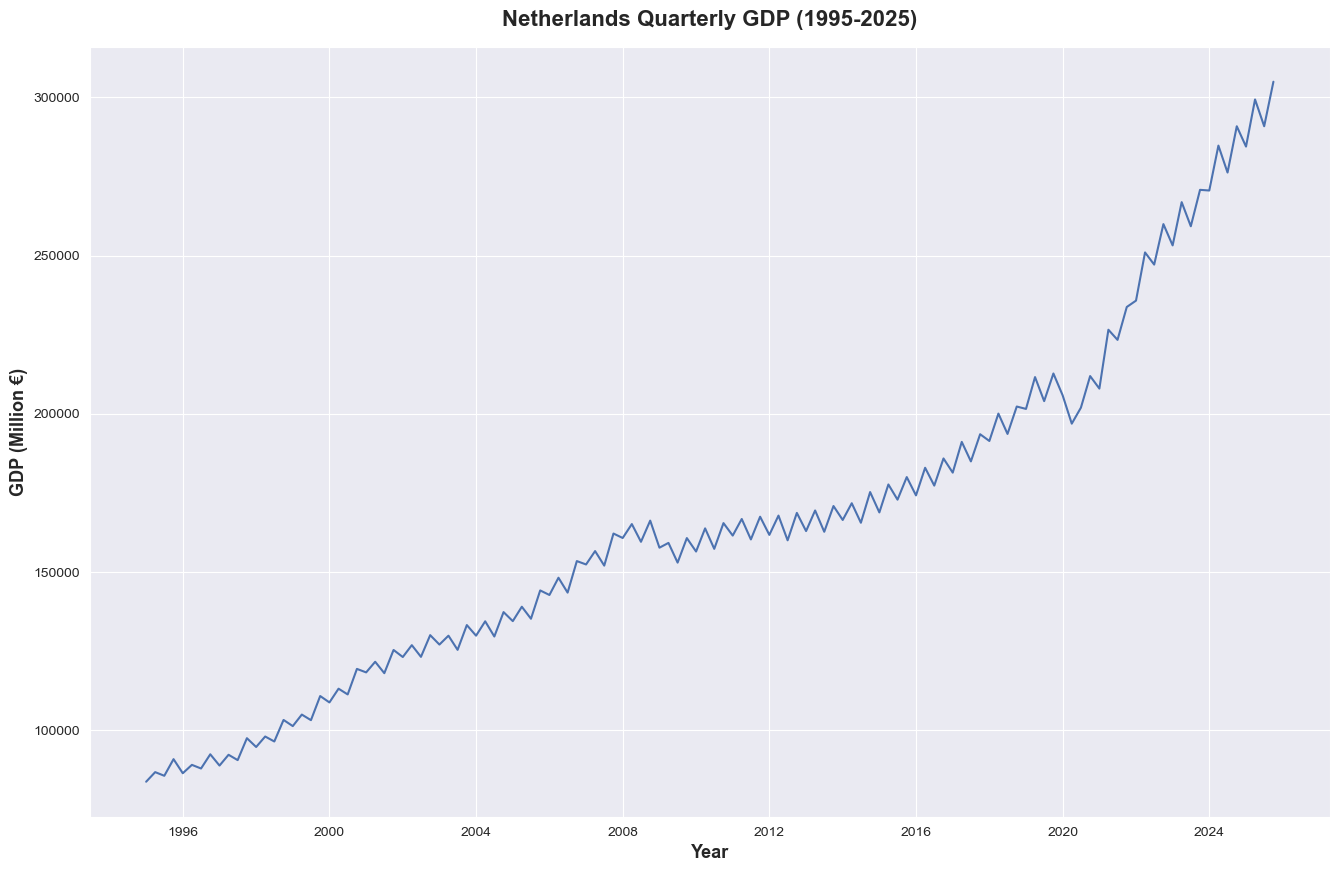

In [155]:
# Convert Year column to datetime for better plotting
GDP_NL['Year'] = pd.to_datetime(GDP_NL['Year'])


# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 1, figsize=(16, 10))

# Plot 1: GDP over time
axes.plot(GDP_NL['Year'], GDP_NL['GDP'])
axes.set_title('Netherlands Quarterly GDP (1995-2025)', 
                  fontsize=16, fontweight='bold', pad=15)
axes.set_xlabel('Year', fontsize=13, fontweight='bold')
axes.set_ylabel('GDP (Million €)', fontsize=13, fontweight='bold')

## Population

|Data       |Granularity |Year range|Source |
|-----------|------------|----------|-------|
|Population |Quarterly      |1900-2025 |CBS    |

In [86]:
pop = pd.read_csv('raw_data/PopulationNL.csv')

popNL = pop[['TIME_PERIOD', 'OBS_VALUE']].copy()
popNL.columns = ['Year', 'Population']

popNL

,Year,Population
0,1995-Q1,15432.0
1,1995-Q2,15450.0
2,1995-Q3,15468.0
3,1995-Q4,15486.0
4,1996-Q1,15504.0
...,...,...
119,2024-Q4,18039.0
120,2025-Q1,18053.0
121,2025-Q2,18074.0
122,2025-Q3,18095.0


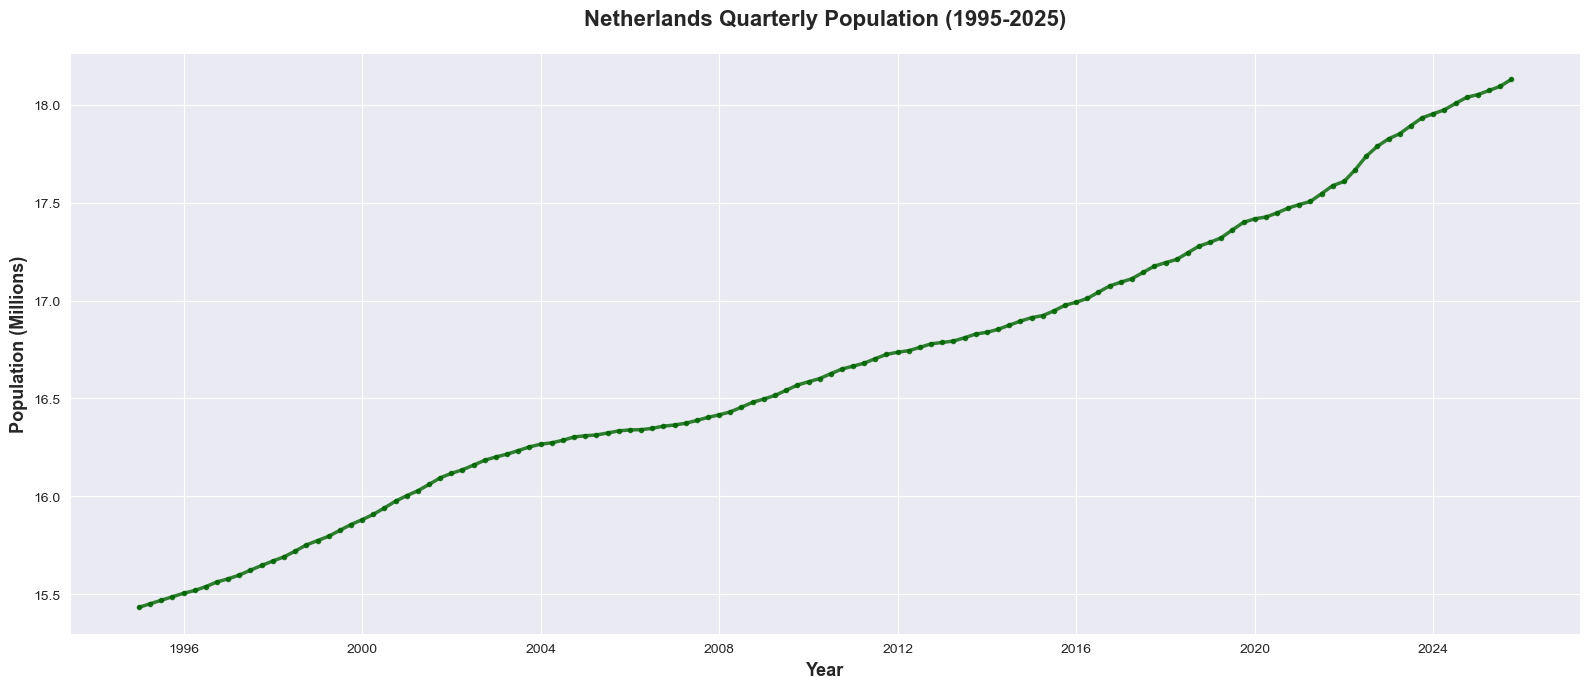


=== Netherlands Population Summary ===
Period: 1995-Qq to 2025-Qq
Starting Population: 15.43 million
Ending Population: 18.13 million
Total Growth: 2.70 million (17.5%)
Average Quarterly Growth: 21.9 thousand


In [88]:
# Convert Year column to datetime for better plotting
popNL['Year'] = pd.to_datetime(popNL['Year'])

# Population is in thousands, so convert to actual numbers
popNL['Population_millions'] = popNL['Population'] / 1000

# Create the plot
plt.figure(figsize=(16, 7))

# Plot population over time
plt.plot(popNL['Year'], popNL['Population_millions'], 
         linewidth=2.5, color='darkgreen', alpha=0.8, marker='o', markersize=3)

# Customize the plot
plt.title('Netherlands Quarterly Population (1995-2025)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=13, fontweight='bold')
plt.ylabel('Population (Millions)', fontsize=13, fontweight='bold')


plt.tight_layout()
plt.savefig("plots/population_nl.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Netherlands Population Summary ===")
print(f"Period: {popNL['Year'].min().strftime('%Y-Q%q')} to {popNL['Year'].max().strftime('%Y-Q%q')}")
print(f"Starting Population: {start_pop:.2f} million")
print(f"Ending Population: {end_pop:.2f} million")
print(f"Total Growth: {total_growth:.2f} million ({pct_growth:.1f}%)")
print(f"Average Quarterly Growth: {popNL['Population'].diff().mean():.1f} thousand")

### Renewable Energy

In [99]:
renewable_erngy_path = 'raw_data/Renewable_electricity_production.csv'
renewaleEnergy = pd.read_csv(renewable_erngy_path, delimiter=';')
renewaleEnergy

,Periods,Total renewable energy sources,Hydropower,"Wind energy, total",Onshore wind energy,Offshore wind energy,Solar photovoltaic,Total biomass,Municipal waste; renewable fraction,Co-firing of biomass in electr. plants,"Biomass boilers companies, CHP",Total biogas,Biogas from landfills,Biogas from sewage water purification,"Biogas, co-digestion of manure",Other biogas
0,1990,807,85,56,56,NaN,0,665,539,NaN,34,91,17,71,NaN,4
1,1991,935,104,88,88,NaN,1,742,588,NaN,34,120,29,87,NaN,4
2,1992,994,120,147,147,NaN,1,726,567,NaN,30,129,32,92,NaN,5
3,1993,1107,92,174,174,NaN,1,839,634,NaN,25,180,78,95,NaN,7
4,1994,1257,100,238,238,NaN,1,918,661,NaN,31,225,124,98,NaN,3
5,1995,1404,88,317,317,NaN,2,998,703,4.0,36,254,142,106,NaN,7
6,1996,1816,80,437,437,NaN,2,1297,953,42.0,30,272,160,102,NaN,10
7,1997,2015,92,475,475,NaN,3,1446,1108,40.0,31,267,145,113,NaN,8
8,1998,2328,112,640,640,NaN,4,1572,1188,101.0,27,257,149,98,NaN,10
9,1999,2509,90,645,645,NaN,5,1768,1261,165.0,66,276,153,109,NaN,14


In [98]:
renewaleEnergy.isna().sum() / len(renewaleEnergy)

Periods                                   0.000000
Total renewable energy sources            0.000000
Hydropower                                0.000000
Wind energy, total                        0.000000
Onshore wind energy                       0.000000
Offshore wind energy                      0.457143
Solar photovoltaic                        0.000000
Total biomass                             0.000000
Municipal waste; renewable fraction       0.000000
Co-firing of biomass in electr. plants    0.142857
Biomass boilers companies, CHP            0.000000
Total biogas                              0.000000
Biogas from landfills                     0.000000
Biogas from sewage water purification     0.000000
Biogas, co-digestion of manure            0.428571
Other biogas                              0.000000
dtype: float64

We can impute NaNs with 0s as they weren't even recorded at the beginning mainly because they hadn't started back then

In [100]:
# Impute NaN values with 0
renewaleEnergy = renewaleEnergy.fillna(0)

In [101]:
renewaleEnergy.isna().sum() / len(renewaleEnergy)

Periods                                   0.0
Total renewable energy sources            0.0
Hydropower                                0.0
Wind energy, total                        0.0
Onshore wind energy                       0.0
Offshore wind energy                      0.0
Solar photovoltaic                        0.0
Total biomass                             0.0
Municipal waste; renewable fraction       0.0
Co-firing of biomass in electr. plants    0.0
Biomass boilers companies, CHP            0.0
Total biogas                              0.0
Biogas from landfills                     0.0
Biogas from sewage water purification     0.0
Biogas, co-digestion of manure            0.0
Other biogas                              0.0
dtype: float64

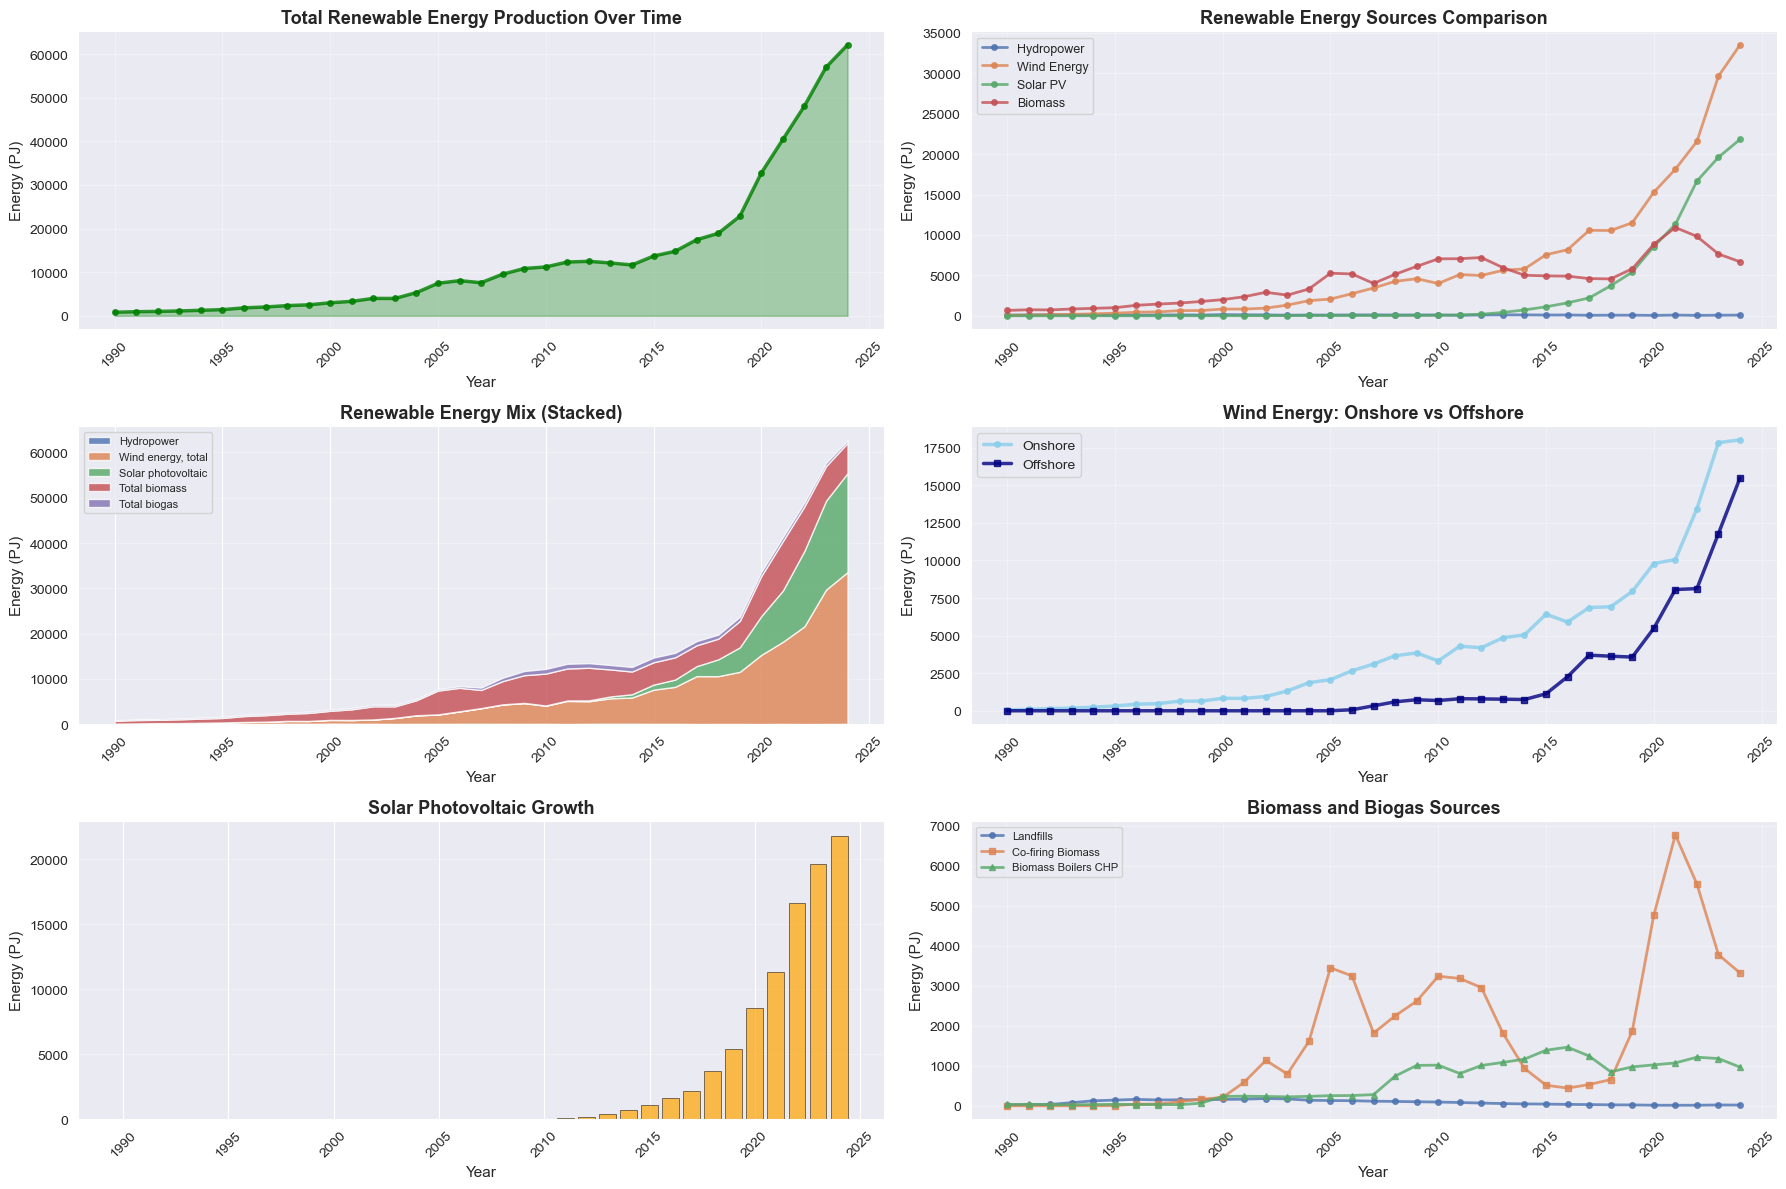

In [104]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# Plot 1: Total Renewable Energy Over Time
ax1 = plt.subplot(3, 2, 1)
ax1.plot(renewaleEnergy['Periods'], renewaleEnergy['Total renewable energy sources'], 
         linewidth=2.5, color='green', alpha=0.8, marker='o', markersize=4)
ax1.fill_between(renewaleEnergy['Periods'], renewaleEnergy['Total renewable energy sources'], 
                  alpha=0.3, color='green')
ax1.set_title('Total Renewable Energy Production Over Time', fontsize=13, fontweight='bold')
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Energy (PJ)', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_axisbelow(True)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Breakdown of Main Renewable Sources
ax2 = plt.subplot(3, 2, 2)
ax2.plot(renewaleEnergy['Periods'], renewaleEnergy['Hydropower'], 
         linewidth=2, marker='o', markersize=4, label='Hydropower', alpha=0.8)
ax2.plot(renewaleEnergy['Periods'], renewaleEnergy['Wind energy, total'], 
         linewidth=2, marker='o', markersize=4, label='Wind Energy', alpha=0.8)
ax2.plot(renewaleEnergy['Periods'], renewaleEnergy['Solar photovoltaic'], 
         linewidth=2, marker='o', markersize=4, label='Solar PV', alpha=0.8)
ax2.plot(renewaleEnergy['Periods'], renewaleEnergy['Total biomass'], 
         linewidth=2, marker='o', markersize=4, label='Biomass', alpha=0.8)
ax2.set_title('Renewable Energy Sources Comparison', fontsize=13, fontweight='bold')
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Energy (PJ)', fontsize=11)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_axisbelow(True)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Stacked Area Chart for Energy Mix
ax3 = plt.subplot(3, 2, 3)
energy_sources = ['Hydropower', 'Wind energy, total', 'Solar photovoltaic', 
                  'Total biomass', 'Total biogas']
ax3.stackplot(renewaleEnergy['Periods'], 
              renewaleEnergy['Hydropower'],
              renewaleEnergy['Wind energy, total'],
              renewaleEnergy['Solar photovoltaic'],
              renewaleEnergy['Total biomass'],
              renewaleEnergy['Total biogas'],
              labels=energy_sources, alpha=0.8)
ax3.set_title('Renewable Energy Mix (Stacked)', fontsize=13, fontweight='bold')
ax3.set_xlabel('Year', fontsize=11)
ax3.set_ylabel('Energy (PJ)', fontsize=11)
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_axisbelow(True)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Wind Energy Breakdown (Onshore vs Offshore)
ax4 = plt.subplot(3, 2, 4)
ax4.plot(renewaleEnergy['Periods'], renewaleEnergy['Onshore wind energy'], 
         linewidth=2.5, marker='o', markersize=4, label='Onshore', alpha=0.8, color='skyblue')
ax4.plot(renewaleEnergy['Periods'], renewaleEnergy['Offshore wind energy'], 
         linewidth=2.5, marker='s', markersize=4, label='Offshore', alpha=0.8, color='navy')
ax4.set_title('Wind Energy: Onshore vs Offshore', fontsize=13, fontweight='bold')
ax4.set_xlabel('Year', fontsize=11)
ax4.set_ylabel('Energy (PJ)', fontsize=11)
ax4.legend(loc='upper left', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_axisbelow(True)
ax4.tick_params(axis='x', rotation=45)

# Plot 5: Solar Growth
ax5 = plt.subplot(3, 2, 5)
ax5.bar(renewaleEnergy['Periods'], renewaleEnergy['Solar photovoltaic'], 
        color='orange', alpha=0.7, edgecolor='black', linewidth=0.5)
ax5.set_title('Solar Photovoltaic Growth', fontsize=13, fontweight='bold')
ax5.set_xlabel('Year', fontsize=11)
ax5.set_ylabel('Energy (PJ)', fontsize=11)
ax5.grid(True, alpha=0.3, axis='y')
ax5.set_axisbelow(True)
ax5.tick_params(axis='x', rotation=45)

# Plot 6: Biogas Sources
ax6 = plt.subplot(3, 2, 6)
ax6.plot(renewaleEnergy['Periods'], renewaleEnergy['Biogas from landfills'], 
         linewidth=2, marker='o', markersize=4, label='Landfills', alpha=0.8)
ax6.plot(renewaleEnergy['Periods'], renewaleEnergy['Co-firing of biomass in electr. plants'], 
         linewidth=2, marker='s', markersize=4, label='Co-firing Biomass', alpha=0.8)
ax6.plot(renewaleEnergy['Periods'], renewaleEnergy['Biomass boilers companies, CHP'], 
         linewidth=2, marker='^', markersize=4, label='Biomass Boilers CHP', alpha=0.8)
ax6.set_title('Biomass and Biogas Sources', fontsize=13, fontweight='bold')
ax6.set_xlabel('Year', fontsize=11)
ax6.set_ylabel('Energy (PJ)', fontsize=11)
ax6.legend(loc='upper left', fontsize=8)
ax6.grid(True, alpha=0.3)
ax6.set_axisbelow(True)
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/renewable_energy_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

The renewable energy plots reveal a dramatic transformation in the Netherlands' energy landscape from 1980 to 2025. Total renewable energy production has grown exponentially, particularly accelerating after 2015, reaching over 60,000 PJ by 2025—a remarkable increase from less than 1,000 PJ in 1980.

The energy mix has fundamentally shifted over this period. In the early years, biomass dominated renewable production, but the stacked area chart shows wind and solar emerging as dominant forces in recent years. Wind energy experienced two distinct growth phases: steady onshore development from the 1990s through 2015, followed by explosive offshore wind expansion after 2015, with offshore capacity now surpassing onshore. Solar photovoltaic shows perhaps the most dramatic growth trajectory, remaining nearly negligible until 2010 but then experiencing exponential growth, particularly after 2015, becoming one of the largest renewable sources by 2025.

Hydropower has remained relatively stable and modest throughout the period, reflecting the Netherlands' geographical limitations for large-scale hydroelectric projects. Biomass sources, including co-firing in power plants and biomass boilers, show significant volatility with peaks around 2000 and 2020, likely reflecting policy changes and market dynamics. The biogas contribution from landfills has remained consistently small but stable. Overall, these plots illustrate the Netherlands' successful energy transition, with wind and solar now driving the renewable energy revolution after decades of biomass-dominated production.

## Merge Datasets

Energy demand dataframes: `data`

Climate predictos dataframes: `weather`

Economic predictors dataframes: `energyPriceNl_clean`, `GDP_NL`, `popNL`, `renewaleEnergy`


In [140]:
data

,loadConsumption,date,datetime,Hour,Year,Month,DayOfWeek,Season
datetime,,,,,,,,
2005-12-31 23:00:00,10215.0000,2006-01-01,2005-12-31 23:00:00,0,2006,12,Sunday,Winter
2006-01-01 00:00:00,9979.0000,2006-01-01,2006-01-01 00:00:00,1,2006,1,Sunday,Winter
2006-01-01 01:00:00,9460.0000,2006-01-01,2006-01-01 01:00:00,2,2006,1,Sunday,Winter
2006-01-01 02:00:00,8833.0000,2006-01-01,2006-01-01 02:00:00,3,2006,1,Sunday,Winter
2006-01-01 03:00:00,8525.0000,2006-01-01,2006-01-01 03:00:00,4,2006,1,Sunday,Winter
...,...,...,...,...,...,...,...,...
2025-09-30 19:00:00,14224.9775,2025-09-30,2025-09-30 19:00:00,20,2025,9,Tuesday,Fall
2025-09-30 20:00:00,13410.5000,2025-09-30,2025-09-30 20:00:00,21,2025,9,Tuesday,Fall
2025-09-30 21:00:00,12497.6325,2025-09-30,2025-09-30 21:00:00,22,2025,9,Tuesday,Fall


In [115]:
weather.head()

,Date,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,1995-01-01,8.3,1.7,12,2.0,2,14,3.8,19,4.6,7.7,20,2.6,1,1,1995,52,199552,Sunday
1,1995-01-02,3.2,1.2,4,3.0,-12,24,5.9,12,4.6,7.7,7,1.0,24,1,1995,1,199501,Monday
2,1995-01-03,-0.1,-0.1,3,-0.5,-38,24,2.3,14,2.1,3.1,12,1.0,1,1,1995,1,199501,Tuesday
3,1995-01-04,0.0,0.0,1,-2.8,-48,21,0.3,14,2.6,4.1,14,2.1,1,1,1995,1,199501,Wednesday
4,1995-01-05,0.0,0.0,1,-3.9,-59,8,-1.8,14,5.7,7.7,21,3.1,1,1,1995,1,199501,Thursday


In [156]:
merged_data = data.merge(weather, left_on='date', right_on='Date', how='left')

In [157]:
merged_data.shape

(173107, 27)

In [158]:
# Define the desired column order
column_order = [
    'date',
    'datetime', 
    'Year_x',
    'Month_x',
    'DayOfWeek',
    'Hour',
    'Season',
    'loadConsumption',
    'DailyPrecipitation',
    'MaxHourlyPrecipitation', 
    'HDMaxPrecipitation', 
    'DailyMeanTemperature',
    'HourlyMinTemperature', 
    'HDMinTemperature', 
    'HourlyMaxTemperature',
    'HDMaxTemperature', 
    'DailyMeanWindspeed', 
    'MaxHourlyMeanWindspeed',
    'HDMaxMeanWindspeed', 
    'MinHourlyMeanWindspeed', 
    'HDMinMeanWindspeed'
]

# Check which columns are actually in the merged dataset
available_cols = [col for col in column_order if col in merged_data.columns]

# Reorder the columns
merged_data = merged_data[available_cols]

# Rename Year_x and Month_x to Year and Month for cleaner names
merged_data = merged_data.rename(columns={'Year_x': 'Year', 'Month_x': 'Month'})

# Show the dataset
merged_data.head()

,date,datetime,Year,Month,DayOfWeek,Hour,Season,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,...,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed
0,2006-01-01,2005-12-31 23:00:00,2006,12,Sunday,0,Winter,10215.0,0.0,0.0,...,4.0,23.0,7.0,5.3,13.0,2.4,4.0,1.0,1.0,15.0
1,2006-01-01,2006-01-01 00:00:00,2006,1,Sunday,1,Winter,9979.0,0.0,0.0,...,4.0,23.0,7.0,5.3,13.0,2.4,4.0,1.0,1.0,15.0
2,2006-01-01,2006-01-01 01:00:00,2006,1,Sunday,2,Winter,9460.0,0.0,0.0,...,4.0,23.0,7.0,5.3,13.0,2.4,4.0,1.0,1.0,15.0
3,2006-01-01,2006-01-01 02:00:00,2006,1,Sunday,3,Winter,8833.0,0.0,0.0,...,4.0,23.0,7.0,5.3,13.0,2.4,4.0,1.0,1.0,15.0
4,2006-01-01,2006-01-01 03:00:00,2006,1,Sunday,4,Winter,8525.0,0.0,0.0,...,4.0,23.0,7.0,5.3,13.0,2.4,4.0,1.0,1.0,15.0


In [159]:
merged_data.shape

(173107, 21)

In [160]:
# Semester 1 is months 1-6, Semester 2 is months 7-12
merged_data['Semester'] = merged_data['Month'].apply(lambda x: '1st semester' if x <= 6 else '2nd semester')

# Create a Periods column in merged_data to match with energyPriceNl_clean
merged_data['Periods'] = merged_data['Year'].astype(str) + ' ' + merged_data['Semester']

# Now merge with energy prices
final_data = merged_data.merge(energyPriceNl_clean, on='Periods', how='left')

# Display the result
print("Final merged dataset shape:", final_data.shape)

# Show the dataset
final_data

Final merged dataset shape: (173107, 37)


,date,datetime,Year,Month,DayOfWeek,Hour,Season,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,...,Electricity price|Consumption bands households|5 until 15 MWh,Electricity price|Consumption bands households|15 MWh and higher,Electricity price|Consumption bands non-households|Less than 20 MWh,Electricity price|Consumption bands non-households|20 unitl 500 MWh,Electricity price|Consumption bands non-households|500 until 2 000 MWh,Electricity price|Consumption bands non-households|2 000 until 20 000 MWh,Electricity price|Consumption bands non-households|20 000 until 70 000 MWh,Electricity price|Consumption bands non-households|70 000 until 150 000 MWh,Electricity price|Consumption bands non-households|150 000 MWh and higher,Average_Household_Price
0,2006-01-01,2005-12-31 23:00:00,2006,12,Sunday,0,Winter,10215.0000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-01,2006-01-01 00:00:00,2006,1,Sunday,1,Winter,9979.0000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-01-01,2006-01-01 01:00:00,2006,1,Sunday,2,Winter,9460.0000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-01-01,2006-01-01 02:00:00,2006,1,Sunday,3,Winter,8833.0000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-01-01,2006-01-01 03:00:00,2006,1,Sunday,4,Winter,8525.0000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173102,2025-09-30,2025-09-30 19:00:00,2025,9,Tuesday,20,Fall,14224.9775,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173103,2025-09-30,2025-09-30 20:00:00,2025,9,Tuesday,21,Fall,13410.5000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173104,2025-09-30,2025-09-30 21:00:00,2025,9,Tuesday,22,Fall,12497.6325,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173105,2025-09-30,2025-09-30 22:00:00,2025,9,Tuesday,23,Fall,11788.7800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
# Create Year-Quarter column in GDP_NL
GDP_NL['Year'] = pd.to_datetime(GDP_NL['Year'])
GDP_NL['Year-Quarter'] = GDP_NL['Year'].dt.year.astype(str) + '-Q' + GDP_NL['Year'].dt.quarter.astype(str)

# Create Year-Quarter column in final_data
final_data['Quarter'] = final_data['datetime'].dt.quarter
final_data['Year-Quarter'] = final_data['Year'].astype(str) + '-Q' + final_data['Quarter'].astype(str)

# Now merge on Year-Quarter
final_data = final_data.merge(GDP_NL[['Year-Quarter', 'GDP']], 
                               on='Year-Quarter', 
                               how='left')

In [163]:
final_data.shape
final_data.head()

,date,datetime,Year,Month,DayOfWeek,Hour,Season,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,...,Electricity price|Consumption bands non-households|20 unitl 500 MWh,Electricity price|Consumption bands non-households|500 until 2 000 MWh,Electricity price|Consumption bands non-households|2 000 until 20 000 MWh,Electricity price|Consumption bands non-households|20 000 until 70 000 MWh,Electricity price|Consumption bands non-households|70 000 until 150 000 MWh,Electricity price|Consumption bands non-households|150 000 MWh and higher,Average_Household_Price,Quarter,Year-Quarter,GDP
0,2006-01-01,2005-12-31 23:00:00,2006,12,Sunday,0,Winter,10215.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2006-Q4,153396.0
1,2006-01-01,2006-01-01 00:00:00,2006,1,Sunday,1,Winter,9979.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2006-Q1,142677.0
2,2006-01-01,2006-01-01 01:00:00,2006,1,Sunday,2,Winter,9460.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2006-Q1,142677.0
3,2006-01-01,2006-01-01 02:00:00,2006,1,Sunday,3,Winter,8833.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2006-Q1,142677.0
4,2006-01-01,2006-01-01 03:00:00,2006,1,Sunday,4,Winter,8525.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2006-Q1,142677.0


In [164]:
popNL.head()

,Year,Population,Population_millions
0,1995-01-01,15432.0,15.432
1,1995-04-01,15450.0,15.450
2,1995-07-01,15468.0,15.468
3,1995-10-01,15486.0,15.486
4,1996-01-01,15504.0,15.504


In [165]:
# Create Year-Quarter column in popNL
popNL['Year'] = pd.to_datetime(popNL['Year'])
popNL['Year-Quarter'] = popNL['Year'].dt.year.astype(str) + '-Q' + popNL['Year'].dt.quarter.astype(str)


# Now merge on Year-Quarter
final_data = final_data.merge(popNL[['Year-Quarter', 'Population']], 
                               on='Year-Quarter', 
                               how='left')

final_data.shape

(173107, 41)

In [166]:
renewaleEnergy.head()

,Periods,Total renewable energy sources,Hydropower,"Wind energy, total",Onshore wind energy,Offshore wind energy,Solar photovoltaic,Total biomass,Municipal waste; renewable fraction,Co-firing of biomass in electr. plants,"Biomass boilers companies, CHP",Total biogas,Biogas from landfills,Biogas from sewage water purification,"Biogas, co-digestion of manure",Other biogas
0,1990,807,85,56,56,0.0,0,665,539,0.0,34,91,17,71,0.0,4
1,1991,935,104,88,88,0.0,1,742,588,0.0,34,120,29,87,0.0,4
2,1992,994,120,147,147,0.0,1,726,567,0.0,30,129,32,92,0.0,5
3,1993,1107,92,174,174,0.0,1,839,634,0.0,25,180,78,95,0.0,7
4,1994,1257,100,238,238,0.0,1,918,661,0.0,31,225,124,98,0.0,3


In [167]:
# Rename the Periods column in renewaleEnergy to Year for clarity
renewaleEnergy_yearly = renewaleEnergy.copy()
renewaleEnergy_yearly = renewaleEnergy_yearly.rename(columns={'Periods': 'Year_renewable'})

# Make sure Year is integer in both datasets
renewaleEnergy_yearly['Year_renewable'] = renewaleEnergy_yearly['Year_renewable'].astype(int)

# Merge with final_data based on Year
final_data = final_data.merge(renewaleEnergy_yearly, 
                               left_on='Year', 
                               right_on='Year_renewable', 
                               how='left')

# Drop the redundant Year_renewable column
final_data = final_data.drop('Year_renewable', axis=1)

In [168]:
final_data

,date,datetime,Year,Month,DayOfWeek,Hour,Season,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,...,Solar photovoltaic,Total biomass,Municipal waste; renewable fraction,Co-firing of biomass in electr. plants,"Biomass boilers companies, CHP",Total biogas,Biogas from landfills,Biogas from sewage water purification,"Biogas, co-digestion of manure",Other biogas
0,2006-01-01,2005-12-31 23:00:00,2006,12,Sunday,0,Winter,10215.0000,0.0,0.0,...,37.0,5173.0,1312.0,3244.0,256.0,361.0,127.0,132.0,59.0,44.0
1,2006-01-01,2006-01-01 00:00:00,2006,1,Sunday,1,Winter,9979.0000,0.0,0.0,...,37.0,5173.0,1312.0,3244.0,256.0,361.0,127.0,132.0,59.0,44.0
2,2006-01-01,2006-01-01 01:00:00,2006,1,Sunday,2,Winter,9460.0000,0.0,0.0,...,37.0,5173.0,1312.0,3244.0,256.0,361.0,127.0,132.0,59.0,44.0
3,2006-01-01,2006-01-01 02:00:00,2006,1,Sunday,3,Winter,8833.0000,0.0,0.0,...,37.0,5173.0,1312.0,3244.0,256.0,361.0,127.0,132.0,59.0,44.0
4,2006-01-01,2006-01-01 03:00:00,2006,1,Sunday,4,Winter,8525.0000,0.0,0.0,...,37.0,5173.0,1312.0,3244.0,256.0,361.0,127.0,132.0,59.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173102,2025-09-30,2025-09-30 19:00:00,2025,9,Tuesday,20,Fall,14224.9775,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173103,2025-09-30,2025-09-30 20:00:00,2025,9,Tuesday,21,Fall,13410.5000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173104,2025-09-30,2025-09-30 21:00:00,2025,9,Tuesday,22,Fall,12497.6325,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173105,2025-09-30,2025-09-30 22:00:00,2025,9,Tuesday,23,Fall,11788.7800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
final_data.isna().sum()

date                                                                               0
datetime                                                                           0
Year                                                                               0
Month                                                                              0
DayOfWeek                                                                          0
Hour                                                                               0
Season                                                                             0
loadConsumption                                                                    0
DailyPrecipitation                                                              6192
MaxHourlyPrecipitation                                                          6192
HDMaxPrecipitation                                                              6192
DailyMeanTemperature                                             

In [170]:
# Get all columns
all_columns = final_data.columns.tolist()

# Create a summary of data availability by year
print("=" * 80)
print("DATA AVAILABILITY BY YEAR FOR EACH COLUMN")
print("=" * 80)

# Group by year and check which columns have non-null values
year_summary = {}

for year in sorted(final_data['Year'].unique()):
    year_data = final_data[final_data['Year'] == year]
    year_summary[year] = {}
    
    for col in all_columns:
        non_null_count = year_data[col].notna().sum()
        total_count = len(year_data)
        year_summary[year][col] = {
            'non_null': non_null_count,
            'total': total_count,
            'pct': (non_null_count / total_count * 100) if total_count > 0 else 0
        }

# Create a more readable summary showing year ranges for each column
print("\nCOLUMN DATA AVAILABILITY SUMMARY:")
print("-" * 80)

column_year_ranges = {}

for col in all_columns:
    years_with_data = []
    for year in sorted(final_data['Year'].unique()):
        if final_data[final_data['Year'] == year][col].notna().any():
            years_with_data.append(year)
    
    if years_with_data:
        min_year = min(years_with_data)
        max_year = max(years_with_data)
        total_years = len(years_with_data)
        column_year_ranges[col] = {
            'min_year': min_year,
            'max_year': max_year,
            'total_years': total_years,
            'year_range': f"{min_year}-{max_year}"
        }
    else:
        column_year_ranges[col] = {
            'min_year': None,
            'max_year': None,
            'total_years': 0,
            'year_range': 'No data'
        }

# Print summary for each column
for col in sorted(all_columns):
    info = column_year_ranges[col]
    if info['total_years'] > 0:
        print(f"{col:50s} : {info['year_range']:15s} ({info['total_years']} years)")
    else:
        print(f"{col:50s} : No data")

# Create a more detailed breakdown by column category
print("\n" + "=" * 80)
print("DETAILED BREAKDOWN BY COLUMN CATEGORY:")
print("=" * 80)

# Categorize columns
time_cols = ['date', 'datetime', 'Year', 'Month', 'DayOfWeek', 'Hour', 'Season', 'Quarter', 'Year-Quarter', 'Periods', 'Semester']
load_cols = ['loadConsumption']
weather_cols = [col for col in all_columns if any(x in col for x in ['Precipitation', 'Temperature', 'Wind', 'Date'])]
price_cols = [col for col in all_columns if 'price' in col.lower() or 'Price' in col]
economic_cols = ['GDP']
renewable_cols = [col for col in all_columns if any(x in col for x in ['renewable', 'Hydropower', 'Wind energy', 'Solar', 'Biomass', 'Biogas', 'Municipal'])]

categories = {
    'Time/Date Columns': time_cols,
    'Load Consumption': load_cols,
    'Weather Variables': weather_cols,
    'Energy Price Variables': price_cols,
    'Economic Indicators': economic_cols,
    'Renewable Energy Variables': renewable_cols
}

for category, cols in categories.items():
    print(f"\n{category}:")
    print("-" * 80)
    for col in cols:
        if col in column_year_ranges:
            info = column_year_ranges[col]
            if info['total_years'] > 0:
                print(f"  {col:48s} : {info['year_range']:15s}")

# Check for columns with missing data in certain years
print("\n" + "=" * 80)
print("COLUMNS WITH GAPS IN DATA:")
print("=" * 80)

for col in all_columns:
    if col in ['date', 'datetime', 'Year', 'Month', 'Hour']:  # Skip obvious complete columns
        continue
    
    years_with_data = set()
    for year in sorted(final_data['Year'].unique()):
        if final_data[final_data['Year'] == year][col].notna().any():
            years_with_data.add(year)
    
    if years_with_data:
        all_years = set(range(min(years_with_data), max(years_with_data) + 1))
        missing_years = sorted(all_years - years_with_data)
        
        if missing_years:
            print(f"\n{col}:")
            print(f"  Data available: {min(years_with_data)}-{max(years_with_data)}")
            print(f"  Missing years: {missing_years}")

print("\n" + "=" * 80)

DATA AVAILABILITY BY YEAR FOR EACH COLUMN

COLUMN DATA AVAILABILITY SUMMARY:
--------------------------------------------------------------------------------
Average_Household_Price                            : 2009-2024       (16 years)
Biogas from landfills                              : 2006-2024       (19 years)
Biogas from sewage water purification              : 2006-2024       (19 years)
Biogas, co-digestion of manure                     : 2006-2024       (19 years)
Biomass boilers companies, CHP                     : 2006-2024       (19 years)
Co-firing of biomass in electr. plants             : 2006-2024       (19 years)
DailyMeanTemperature                               : 2006-2025       (20 years)
DailyMeanWindspeed                                 : 2006-2025       (20 years)
DailyPrecipitation                                 : 2006-2025       (20 years)
DayOfWeek                                          : 2006-2025       (20 years)
Electricity price|Consumption bands househ